## variogram parameters

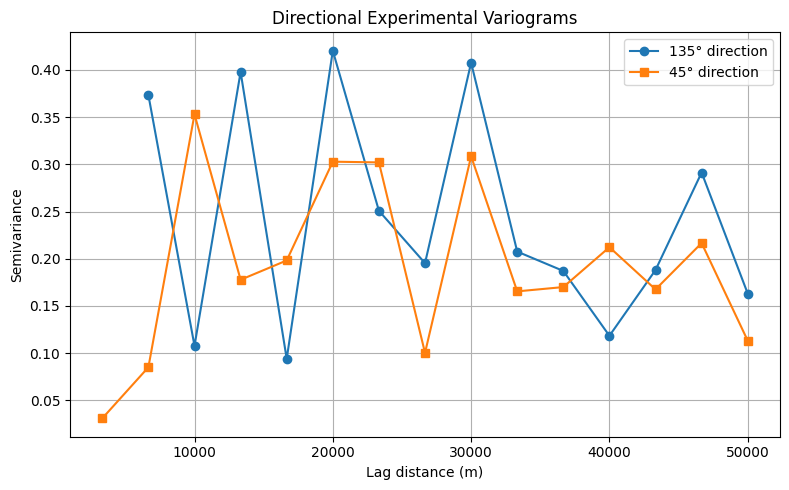

In [12]:
##variogram (w rui help)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skgstat import DirectionalVariogram
import os

# =====================================
# 1. Load data
# =====================================
df = pd.read_csv('/Users/inesschwartz/Desktop/model/decluster_runs/decluster_run_001.csv')

coords = df[['X_coord', 'Y_coord']].values
values = df['log_soc_stock'].values

# =====================================
# 2. Define parameters
# =====================================
n_lags = 15
maxlag_km = 50       # max lag in km
maxlag = maxlag_km * 1000  # convert to meters if your coords are in meters
tolerance = 22.5
normalize = True
estimator = 'matheron'

# Directions (azimuths, in degrees)
dir1 = 135
dir2 = 45

# =====================================
# 3. Compute directional variograms
# =====================================
v135 = DirectionalVariogram(
    coordinates=coords,
    values=values,
    azimuth=dir1,
    n_lags=n_lags,
    maxlag=maxlag,
    tolerance=tolerance,
    normalize=normalize,
    estimator=estimator
)

v45 = DirectionalVariogram(
    coordinates=coords,
    values=values,
    azimuth=dir2,
    n_lags=n_lags,
    maxlag=maxlag,
    tolerance=tolerance,
    normalize=normalize,
    estimator=estimator
)

# =====================================
# 4. Plot results
# =====================================
plt.figure(figsize=(8,5))
plt.plot(v135.bins, v135.experimental, 'o-', label='135° direction')
plt.plot(v45.bins, v45.experimental, 's-', label='45° direction')
plt.xlabel('Lag distance (m)')
plt.ylabel('Semivariance')
plt.title('Directional Experimental Variograms')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


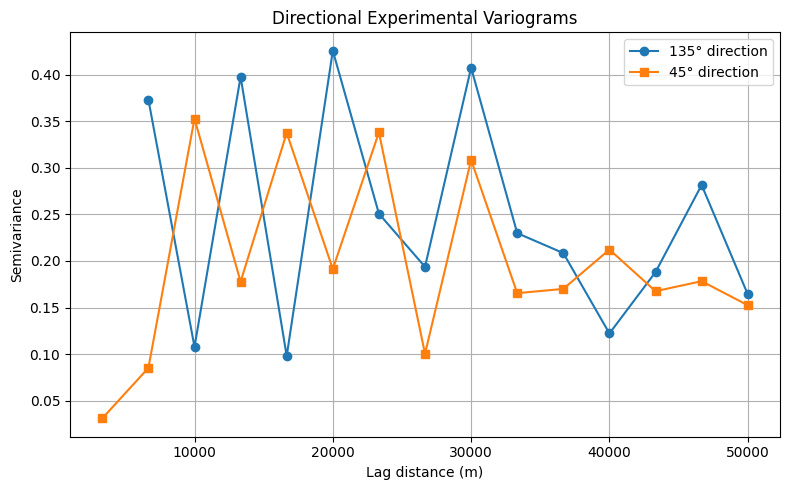

In [13]:
# dc 5
# #variogram (w rui help)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skgstat import DirectionalVariogram
import os

# =====================================
# 1. Load data
# =====================================
df = pd.read_csv('/Users/inesschwartz/Desktop/model/decluster_runs/decluster_run_005.csv')

coords = df[['X_coord', 'Y_coord']].values
values = df['log_soc_stock'].values

# =====================================
# 2. Define parameters
# =====================================
n_lags = 15
maxlag_km = 50       # max lag in km
maxlag = maxlag_km * 1000  # convert to meters if your coords are in meters
tolerance = 22.5
normalize = True
estimator = 'matheron'

# Directions (azimuths, in degrees)
dir1 = 135
dir2 = 45

# =====================================
# 3. Compute directional variograms
# =====================================
v135 = DirectionalVariogram(
    coordinates=coords,
    values=values,
    azimuth=dir1,
    n_lags=n_lags,
    maxlag=maxlag,
    tolerance=tolerance,
    normalize=normalize,
    estimator=estimator
)

v45 = DirectionalVariogram(
    coordinates=coords,
    values=values,
    azimuth=dir2,
    n_lags=n_lags,
    maxlag=maxlag,
    tolerance=tolerance,
    normalize=normalize,
    estimator=estimator
)

# =====================================
# 4. Plot results
# =====================================
plt.figure(figsize=(8,5))
plt.plot(v135.bins, v135.experimental, 'o-', label='135° direction')
plt.plot(v45.bins, v45.experimental, 's-', label='45° direction')
plt.xlabel('Lag distance (m)')
plt.ylabel('Semivariance')
plt.title('Directional Experimental Variograms')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


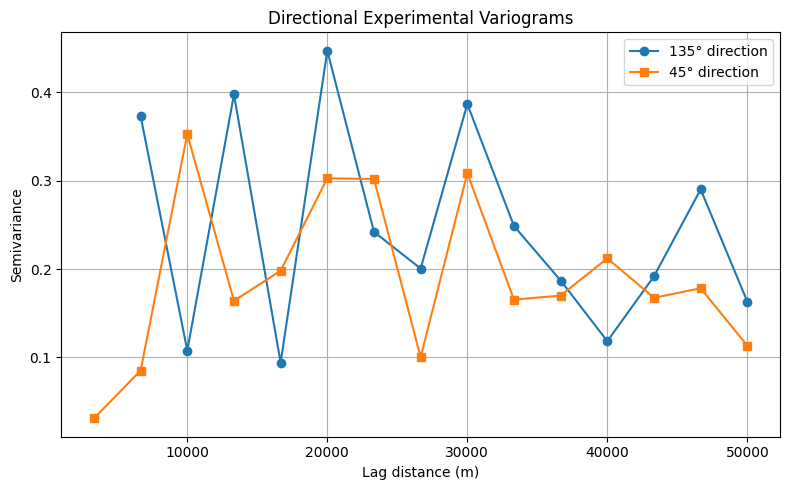

In [14]:
##dc 10
##variogram (w rui help)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skgstat import DirectionalVariogram
import os

# =====================================
# 1. Load data
# =====================================
df = pd.read_csv('/Users/inesschwartz/Desktop/model/decluster_runs/decluster_run_010.csv')

coords = df[['X_coord', 'Y_coord']].values
values = df['log_soc_stock'].values

# =====================================
# 2. Define parameters
# =====================================
n_lags = 15
maxlag_km = 50       # max lag in km
maxlag = maxlag_km * 1000  # convert to meters if your coords are in meters
tolerance = 22.5
normalize = True
estimator = 'matheron'

# Directions (azimuths, in degrees)
dir1 = 135
dir2 = 45

# =====================================
# 3. Compute directional variograms
# =====================================
v135 = DirectionalVariogram(
    coordinates=coords,
    values=values,
    azimuth=dir1,
    n_lags=n_lags,
    maxlag=maxlag,
    tolerance=tolerance,
    normalize=normalize,
    estimator=estimator
)

v45 = DirectionalVariogram(
    coordinates=coords,
    values=values,
    azimuth=dir2,
    n_lags=n_lags,
    maxlag=maxlag,
    tolerance=tolerance,
    normalize=normalize,
    estimator=estimator
)

# =====================================
# 4. Plot results
# =====================================
plt.figure(figsize=(8,5))
plt.plot(v135.bins, v135.experimental, 'o-', label='135° direction')
plt.plot(v45.bins, v45.experimental, 's-', label='45° direction')
plt.xlabel('Lag distance (m)')
plt.ylabel('Semivariance')
plt.title('Directional Experimental Variograms')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


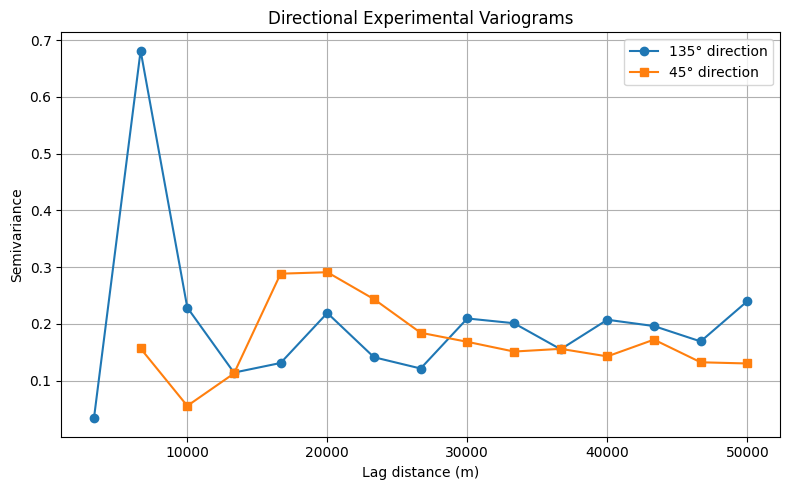

In [16]:
##dc 20
##variogram (w rui help)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skgstat import DirectionalVariogram
import os

# =====================================
# 1. Load data
# =====================================
df = pd.read_csv('/Users/inesschwartz/Desktop/model/decluster_runs/decluster_run_020.csv')

coords = df[['X_coord', 'Y_coord']].values
values = df['log_soc_stock'].values

# =====================================
# 2. Define parameters
# =====================================
n_lags = 15
maxlag_km = 50       # max lag in km
maxlag = maxlag_km * 1000  # convert to meters if your coords are in meters
tolerance = 22.5
normalize = True
estimator = 'matheron'

# Directions (azimuths, in degrees)
dir1 = 135
dir2 = 45

# =====================================
# 3. Compute directional variograms
# =====================================
v135 = DirectionalVariogram(
    coordinates=coords,
    values=values,
    azimuth=dir1,
    n_lags=n_lags,
    maxlag=maxlag,
    tolerance=tolerance,
    normalize=normalize,
    estimator=estimator
)

v45 = DirectionalVariogram(
    coordinates=coords,
    values=values,
    azimuth=dir2,
    n_lags=n_lags,
    maxlag=maxlag,
    tolerance=tolerance,
    normalize=normalize,
    estimator=estimator
)

# =====================================
# 4. Plot results
# =====================================
plt.figure(figsize=(8,5))
plt.plot(v135.bins, v135.experimental, 'o-', label='135° direction')
plt.plot(v45.bins, v45.experimental, 's-', label='45° direction')
plt.xlabel('Lag distance (m)')
plt.ylabel('Semivariance')
plt.title('Directional Experimental Variograms')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


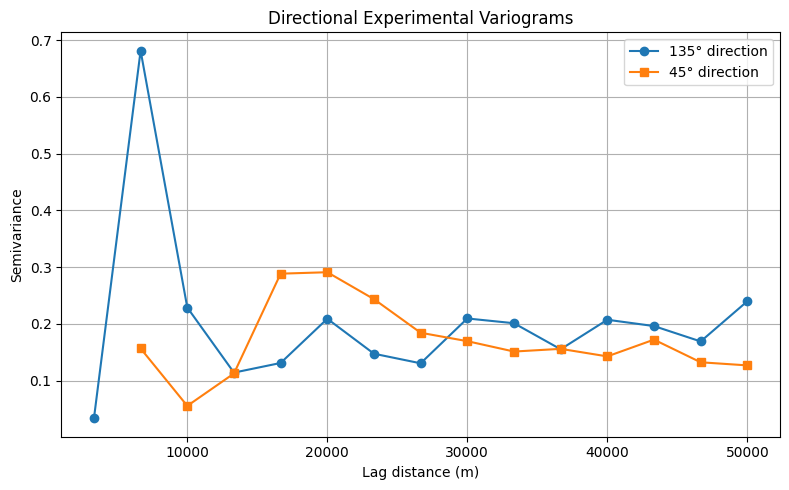

In [17]:
##dc 30
##variogram (w rui help)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skgstat import DirectionalVariogram
import os

# =====================================
# 1. Load data
# =====================================
df = pd.read_csv('/Users/inesschwartz/Desktop/model/decluster_runs/decluster_run_030.csv')

coords = df[['X_coord', 'Y_coord']].values
values = df['log_soc_stock'].values

# =====================================
# 2. Define parameters
# =====================================
n_lags = 15
maxlag_km = 50       # max lag in km
maxlag = maxlag_km * 1000  # convert to meters if your coords are in meters
tolerance = 22.5
normalize = True
estimator = 'matheron'

# Directions (azimuths, in degrees)
dir1 = 135
dir2 = 45

# =====================================
# 3. Compute directional variograms
# =====================================
v135 = DirectionalVariogram(
    coordinates=coords,
    values=values,
    azimuth=dir1,
    n_lags=n_lags,
    maxlag=maxlag,
    tolerance=tolerance,
    normalize=normalize,
    estimator=estimator
)

v45 = DirectionalVariogram(
    coordinates=coords,
    values=values,
    azimuth=dir2,
    n_lags=n_lags,
    maxlag=maxlag,
    tolerance=tolerance,
    normalize=normalize,
    estimator=estimator
)

# =====================================
# 4. Plot results
# =====================================
plt.figure(figsize=(8,5))
plt.plot(v135.bins, v135.experimental, 'o-', label='135° direction')
plt.plot(v45.bins, v45.experimental, 's-', label='45° direction')
plt.xlabel('Lag distance (m)')
plt.ylabel('Semivariance')
plt.title('Directional Experimental Variograms')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


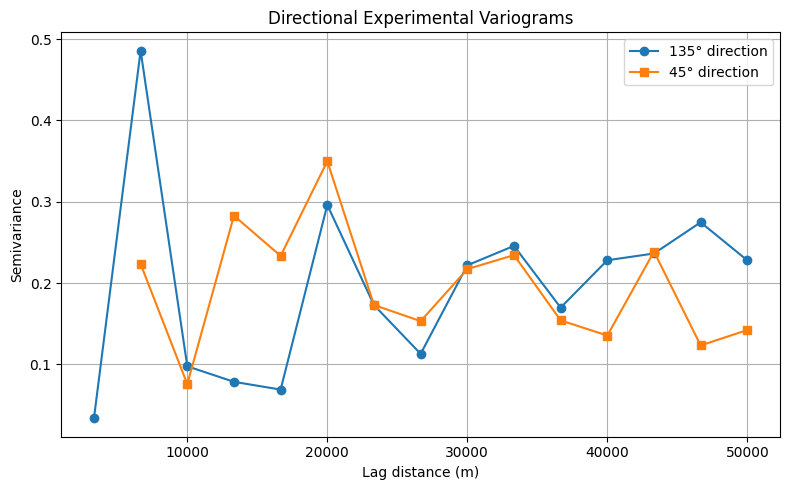

In [18]:
##dc 40
##variogram (w rui help)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skgstat import DirectionalVariogram
import os

# =====================================
# 1. Load data
# =====================================
df = pd.read_csv('/Users/inesschwartz/Desktop/model/decluster_runs/decluster_run_040.csv')

coords = df[['X_coord', 'Y_coord']].values
values = df['log_soc_stock'].values

# =====================================
# 2. Define parameters
# =====================================
n_lags = 15
maxlag_km = 50       # max lag in km
maxlag = maxlag_km * 1000  # convert to meters if your coords are in meters
tolerance = 22.5
normalize = True
estimator = 'matheron'

# Directions (azimuths, in degrees)
dir1 = 135
dir2 = 45

# =====================================
# 3. Compute directional variograms
# =====================================
v135 = DirectionalVariogram(
    coordinates=coords,
    values=values,
    azimuth=dir1,
    n_lags=n_lags,
    maxlag=maxlag,
    tolerance=tolerance,
    normalize=normalize,
    estimator=estimator
)

v45 = DirectionalVariogram(
    coordinates=coords,
    values=values,
    azimuth=dir2,
    n_lags=n_lags,
    maxlag=maxlag,
    tolerance=tolerance,
    normalize=normalize,
    estimator=estimator
)

# =====================================
# 4. Plot results
# =====================================
plt.figure(figsize=(8,5))
plt.plot(v135.bins, v135.experimental, 'o-', label='135° direction')
plt.plot(v45.bins, v45.experimental, 's-', label='45° direction')
plt.xlabel('Lag distance (m)')
plt.ylabel('Semivariance')
plt.title('Directional Experimental Variograms')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


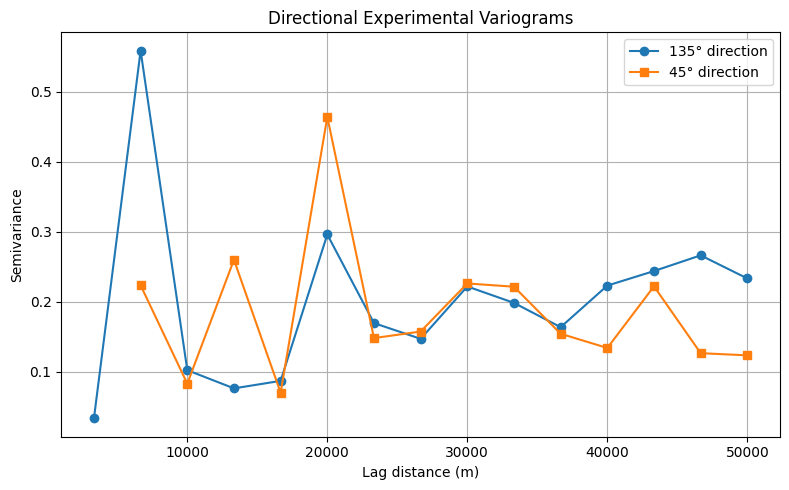

In [20]:
##dc 50
##variogram (w rui help)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skgstat import DirectionalVariogram
import os

# =====================================
# 1. Load data
# =====================================
df = pd.read_csv('/Users/inesschwartz/Desktop/model/decluster_runs/decluster_run_050.csv')

coords = df[['X_coord', 'Y_coord']].values
values = df['log_soc_stock'].values

# =====================================
# 2. Define parameters
# =====================================
n_lags = 15
maxlag_km = 50       # max lag in km
maxlag = maxlag_km * 1000  # convert to meters if your coords are in meters
tolerance = 22.5
normalize = True
estimator = 'matheron'

# Directions (azimuths, in degrees)
dir1 = 135
dir2 = 45

# =====================================
# 3. Compute directional variograms
# =====================================
v135 = DirectionalVariogram(
    coordinates=coords,
    values=values,
    azimuth=dir1,
    n_lags=n_lags,
    maxlag=maxlag,
    tolerance=tolerance,
    normalize=normalize,
    estimator=estimator
)

v45 = DirectionalVariogram(
    coordinates=coords,
    values=values,
    azimuth=dir2,
    n_lags=n_lags,
    maxlag=maxlag,
    tolerance=tolerance,
    normalize=normalize,
    estimator=estimator
)

# =====================================
# 4. Plot results
# =====================================
plt.figure(figsize=(8,5))
plt.plot(v135.bins, v135.experimental, 'o-', label='135° direction')
plt.plot(v45.bins, v45.experimental, 's-', label='45° direction')
plt.xlabel('Lag distance (m)')
plt.ylabel('Semivariance')
plt.title('Directional Experimental Variograms')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Best parameter search for OK of model declustered tifs

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from pykrige.ok import OrdinaryKriging
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# ======================================
# 1. Load one declustered dataset
# ======================================
csv_path = "/Users/inesschwartz/Desktop/model/decluster_runs_aligned/decluster_run_050.csv"
df = pd.read_csv(csv_path)

coords = df[["X_coord", "Y_coord"]].values
values = df["log_soc_stock"].values

# ======================================
# 2. Metric helper
# ======================================
def compute_metrics(y_true, y_pred):
    return {
        "R2":  r2_score(y_true, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "MAE": mean_absolute_error(y_true, y_pred)
    }

# ======================================
# 3. LOO OK CV for single variogram
# ======================================
def loo_ok_cv(coords, values, var, model="spherical"):
    n = len(values)
    preds = np.zeros(n, dtype=float)

    for i in range(n):
        mask = np.ones(n, dtype=bool)
        mask[i] = False

        ok = OrdinaryKriging(
            x=coords[mask, 0],
            y=coords[mask, 1],
            z=values[mask],
            variogram_model=model,
            variogram_parameters={
                "sill": var["sill"],
                "range": var["range"],
                "nugget": var["nugget"],
                "anisotropy_scaling": var["anisotropy_scaling"],
                "anisotropy_angle": var["anisotropy_angle"],
            },
            enable_plotting=False,
            verbose=False,
        )

        z, _ = ok.execute(
            "points",
            np.array([coords[i, 0]]),
            np.array([coords[i, 1]])
        )
        preds[i] = float(z.data[0])

    metrics = compute_metrics(values, preds)
    return metrics, preds

# ======================================
# 4. Define search grid around eyeballed params
# ======================================

# Center values
base_nugget = 0.06
base_sill   = 0.23
base_range  = 40000
base_scaling = 0.55
base_angle   = 135.0

nuggets   = [0.04, 0.06, 0.08]
sills     = [0.21, 0.23, 0.25]
ranges    = [30000, 40000, 50000]
scalings  = [0.4, 0.55, 0.7]
angles    = [135.0]  # you can add 120, 150 if you want to test

candidate_params = []
for nug in nuggets:
    for sill in sills:
        for r in ranges:
            for sc in scalings:
                for ang in angles:
                    candidate_params.append({
                        "nugget": nug,
                        "sill": sill,
                        "range": r,
                        "anisotropy_scaling": sc,
                        "anisotropy_angle": ang,
                    })

print(f"Testing {len(candidate_params)} candidate variograms...")

# ======================================
# 5. Evaluate each candidate with LOO OK
# ======================================
results = []

for i, var in enumerate(tqdm(candidate_params)):
    metrics, _ = loo_ok_cv(coords, values, var, model="spherical")
    results.append({
        "idx": i,
        "nugget": var["nugget"],
        "sill": var["sill"],
        "range": var["range"],
        "anisotropy_scaling": var["anisotropy_scaling"],
        "anisotropy_angle": var["anisotropy_angle"],
        **metrics
    })

results_df = pd.DataFrame(results)
results_df = results_df.sort_values("RMSE")
print(results_df.head(10))

# Save all results so you can inspect later
out_csv = "/Users/inesschwartz/Desktop/model/ok_variogram_gridsearch_decl50.csv"
results_df.to_csv(out_csv, index=False)
print(f"\nGrid search results saved to: {out_csv}")

# Best model
best = results_df.iloc[0]
print("\nBest variogram (by RMSE):")
print(best)


Testing 81 candidate variograms...


100%|██████████| 81/81 [30:09<00:00, 22.34s/it]

    idx  nugget  sill  range  anisotropy_scaling  anisotropy_angle        R2  \
60   60    0.08  0.21  50000                0.40             135.0  0.203655   
61   61    0.08  0.21  50000                0.55             135.0  0.203655   
62   62    0.08  0.21  50000                0.70             135.0  0.203655   
69   69    0.08  0.23  50000                0.40             135.0  0.202865   
70   70    0.08  0.23  50000                0.55             135.0  0.202865   
71   71    0.08  0.23  50000                0.70             135.0  0.202865   
80   80    0.08  0.25  50000                0.70             135.0  0.201574   
79   79    0.08  0.25  50000                0.55             135.0  0.201574   
78   78    0.08  0.25  50000                0.40             135.0  0.201574   
35   35    0.06  0.21  50000                0.70             135.0  0.199163   

        RMSE       MAE  
60  0.464751  0.350315  
61  0.464751  0.350315  
62  0.464751  0.350315  
69  0.464982  0.350

## IGNORE ALL BELOW THIS
# trying to predict best variogram parameters per decluster subset

## hybrid grid search

Computes directional variograms → uses their parameters as a baseline →
runs a small 3 × 3 × 3 grid search with 5-fold CV around those values.

In [4]:
## best parameters for each decluster (/Users/inesschwartz/Desktop/model/ok_by_decluster/ok_model_selection_merged.csv)
# =========================================================
# Ordinary Kriging Parameter Search — Final Production Script
# =========================================================
# Description:
#   - Computes directional variograms (45°, 135°) per decluster subset
#   - Performs ±20% grid search around estimated parameters
#   - Uses 5-fold CV to select best OK model (lowest RMSE)
#   - Saves per-decluster results to CSV (autosaves every 5)
#   - Designed for ~50 declusters (≈20 min total runtime)
# =========================================================

import os, glob, time, datetime
import numpy as np, pandas as pd
from tqdm import tqdm
from skgstat import DirectionalVariogram
from pykrige.ok import OrdinaryKriging
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# -----------------------------
# 0) User settings
# -----------------------------
decluster_dir = "/Users/inesschwartz/Desktop/model/decluster_runs_aligned"
pattern = "decluster_run_*.csv"   # all decluster subsets
out_dir = "/Users/inesschwartz/Desktop/model/ok_by_decluster"
os.makedirs(out_dir, exist_ok=True)

# Variogram computation params
N_LAGS = 15
MAXLAG = 50_000        # meters
TOL = 22.5
ESTIMATOR = "matheron"

# Candidate theoretical models to test
MODEL_CANDIDATES = ["spherical", "gaussian", "exponential"]

# ±20% grid multipliers
RANGE_MULT = [0.8, 1.0, 1.2]
SILL_MULT  = [0.9, 1.0, 1.1]
NUGG_MULT  = [0.9, 1.0, 1.1]
TEST_ANISO = ["isotropic", "derived"]

# =========================================================
# Helper functions
# =========================================================
def estimate_nugget_sill_range(bins, gamma):
    """Estimate nugget, sill, range (m) from experimental variogram."""
    mask = np.isfinite(bins) & np.isfinite(gamma)
    bins, gamma = np.asarray(bins)[mask], np.asarray(gamma)[mask]
    if len(bins) < 4:
        return np.nan, np.nan, np.nan

    nugget = float(np.nanmin(gamma[:min(3, len(gamma))]))
    sill = float(np.nanmedian(gamma[-max(3, int(len(gamma)/3)):]))
    idx = np.where(gamma >= 0.95 * sill)[0]
    eff_range = float(bins[-1]) if len(idx) == 0 else float(bins[idx[0]])
    return nugget, sill, eff_range


def directional_params(coords, values, azimuth):
    """Compute directional variogram and extract parameters."""
    v = DirectionalVariogram(
        coordinates=coords,
        values=values,
        azimuth=azimuth,
        n_lags=N_LAGS,
        maxlag=MAXLAG,
        tolerance=TOL,
        estimator=ESTIMATOR,
        normalize=True,
    )
    nugget, sill, eff_range = estimate_nugget_sill_range(v.bins, v.experimental)
    return {"azimuth": azimuth, "nugget": nugget, "sill": sill, "range": eff_range}


def derive_geometric_anisotropy(p45, p135):
    """Return anisotropy angle (deg) and scaling (minor/major)."""
    if p45["range"] >= p135["range"]:
        major_dir, major, minor = 45, p45["range"], p135["range"]
    else:
        major_dir, major, minor = 135, p135["range"], p45["range"]
    ratio = float(np.clip(minor / max(major, 1e-6), 0.3, 1.0))
    return major_dir, ratio


def kfold_ok(coords, values, model, params, anisotropy, n_splits=5):
    """5-fold CV R2/RMSE/MAE for an OK configuration."""
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    preds, obs = [], []
    ang, sc = (0.0, 1.0) if anisotropy is None else anisotropy

    for tr, te in kf.split(coords):
        x, y, z = coords[tr, 0], coords[tr, 1], values[tr]
        try:
            OK = OrdinaryKriging(
                x, y, z,
                variogram_model=model,
                variogram_parameters=params,
                anisotropy_angle=ang,
                anisotropy_scaling=sc,
                enable_plotting=False,
                verbose=False,
            )
            z_pred, _ = OK.execute("points", coords[te, 0], coords[te, 1])
            preds.extend(z_pred)
            obs.extend(values[te])
        except Exception:
            continue

    if len(preds) < 5:
        return np.inf, np.inf

    r2 = r2_score(obs, preds)
    rmse = np.sqrt(mean_squared_error(obs, preds))
    mae = mean_absolute_error(obs, preds)
    return rmse, mae


def choose_best_ok(coords, values, p45, p135):
    """Grid-search ±20% around estimated params to find best OK."""
    nug0 = np.nanmedian([p45["nugget"], p135["nugget"]])
    sill0 = np.nanmedian([p45["sill"], p135["sill"]])
    rng0  = np.nanmedian([p45["range"], p135["range"]])
    aniso_angle, aniso_ratio = derive_geometric_anisotropy(p45, p135)
    anis_derived = (aniso_angle, aniso_ratio)

    best = {"rmse": np.inf}
    total = len(MODEL_CANDIDATES)*len(RANGE_MULT)*len(SILL_MULT)*len(NUGG_MULT)*len(TEST_ANISO)
    combo = 0

    for model in MODEL_CANDIDATES:
        for r_m in RANGE_MULT:
            for s_m in SILL_MULT:
                for n_m in NUGG_MULT:
                    params = {"range": max(1000.0, rng0 * r_m),
                              "sill": max(1e-6, sill0 * s_m),
                              "nugget": max(0.0, nug0 * n_m)}
                    for mode in TEST_ANISO:
                        combo += 1
                        anis = None if mode == "isotropic" else anis_derived
                        r2, rmse, mae = kfold_ok(coords, values, model, params, anis)
                        if rmse < best["rmse"]:
                            best = {"model": model,
                                    "params": params,
                                    "anisotropy": anis,
                                    "anisotropy_mode": mode,
                                    "rmse": rmse,
                                    "mae": mae}
    return best, total

# =========================================================
# Main loop
# =========================================================
rows = []
files = sorted(glob.glob(os.path.join(decluster_dir, pattern)))
t_start_all = time.time()

for idx, f in enumerate(files, 1):
    df = pd.read_csv(f)
    if len(df) < 30:
        continue
    coords = df[["X_coord", "Y_coord"]].values
    values = df["log_soc_stock"].values

    print(f"\n▶ [{idx}/{len(files)}] {os.path.basename(f)} ({len(df)} pts)")
    t0 = time.time()

    # Directional variograms
    p45 = directional_params(coords, values, 45)
    p135 = directional_params(coords, values, 135)

    # Grid search for best OK model
    best, total = choose_best_ok(coords, values, p45, p135)
    runtime_min = (time.time() - t0) / 60

    print(f"   Best={best['model']}, r2={best['r2']:.3f}, RMSE={best['rmse']:.3f}, "
          f"MAE={best['mae']:.3f}, Time={runtime_min:.2f} min")

    rows.append({
        "decluster_file": os.path.basename(f),
        "n_points": len(df),
        "p45_nugget": p45["nugget"], "p45_sill": p45["sill"], "p45_range_m": p45["range"],
        "p135_nugget": p135["nugget"], "p135_sill": p135["sill"], "p135_range_m": p135["range"],
        "best_model": best["model"],
        "best_params": best["params"],
        "anisotropy_mode": best["anisotropy_mode"],
        "anisotropy": best["anisotropy"],
        "r2": best["r2"],
        "rmse": best["rmse"],
        "mae": best["mae"],
        "runtime_min": runtime_min
    })

    # Autosave every 5 declusters
    if idx % 5 == 0:
        partial_csv = os.path.join(out_dir, f"ok_model_selection_partial_{idx}.csv")
        pd.DataFrame(rows).to_csv(partial_csv, index=False)
        print(f"   💾 Autosaved progress → {partial_csv}")

# =========================================================
# Final save + runtime summary
# =========================================================
log_df = pd.DataFrame(rows)
out_csv = os.path.join(out_dir, "ok_model_selection_log.csv")
log_df.to_csv(out_csv, index=False)

total_min = sum(r["runtime_min"] for r in rows)
print(f"\n✅ Saved full results → {out_csv}")
print(f"Processed {len(rows)} declusters "
      f"in ≈ {total_min:.1f} min "
      f"({datetime.timedelta(minutes=total_min)}).")



▶ [1/50] decluster_run_001.csv (634 pts)


ValueError: not enough values to unpack (expected 3, got 2)

In [27]:
import pandas as pd, glob, os

out_dir = "/Users/inesschwartz/Desktop/model/ok_by_decluster"
partials = sorted(glob.glob(os.path.join(out_dir, "ok_model_selection_partial_*.csv")))
merged = pd.concat([pd.read_csv(f) for f in partials], ignore_index=True)
merged.to_csv(os.path.join(out_dir, "ok_model_selection_merged.csv"), index=False)
print(f"✅ Merged {len(partials)} partial files → ok_model_selection_merged.csv")
print(f"Total declusters completed: {merged.shape[0]}")


✅ Merged 8 partial files → ok_model_selection_merged.csv
Total declusters completed: 180


In [29]:
import pandas as pd

merged_csv = "/Users/inesschwartz/Desktop/model/ok_by_decluster/ok_model_selection_merged.csv"
done = set(pd.read_csv(merged_csv)["decluster_file"].tolist())
print(f"{len(done)} declusters already processed.")


40 declusters already processed.


In [30]:
# =========================================================
# OK Parameter Search — Resume-safe version
# =========================================================
# Skips already processed declusters (based on merged CSV)
# Autosaves every 2 declusters
# Safe to re-run after crash
# =========================================================

import os, glob, time, datetime, gc
import numpy as np, pandas as pd
from tqdm import tqdm
from skgstat import DirectionalVariogram
from pykrige.ok import OrdinaryKriging
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error

# -----------------------------
# 0) User settings
# -----------------------------
decluster_dir = "/Users/inesschwartz/Desktop/model/decluster_runs"
pattern = "decluster_run_*.csv"
out_dir = "/Users/inesschwartz/Desktop/model/ok_by_decluster"
merged_csv = os.path.join(out_dir, "ok_model_selection_merged.csv")
os.makedirs(out_dir, exist_ok=True)

# Variogram params
N_LAGS = 15
MAXLAG = 50_000
TOL = 22.5
ESTIMATOR = "matheron"
MODEL_CANDIDATES = ["spherical", "gaussian", "exponential"]
RANGE_MULT = [0.8, 1.0, 1.2]
SILL_MULT  = [0.9, 1.0, 1.1]
NUGG_MULT  = [0.9, 1.0, 1.1]
TEST_ANISO = ["isotropic", "derived"]

# -----------------------------
# 1) Load list of already done declusters
# -----------------------------
done = set()
if os.path.exists(merged_csv):
    done = set(pd.read_csv(merged_csv)["decluster_file"].tolist())
    print(f"Resuming run — {len(done)} declusters already completed.")

# -----------------------------
# Helper functions
# -----------------------------
def estimate_nugget_sill_range(bins, gamma):
    mask = np.isfinite(bins) & np.isfinite(gamma)
    bins, gamma = np.asarray(bins)[mask], np.asarray(gamma)[mask]
    if len(bins) < 4:
        return np.nan, np.nan, np.nan
    nug = float(np.nanmin(gamma[:min(3, len(gamma))]))
    sill = float(np.nanmedian(gamma[-max(3, int(len(gamma)/3)):]))
    idx = np.where(gamma >= 0.95 * sill)[0]
    rng = float(bins[-1]) if len(idx) == 0 else float(bins[idx[0]])
    return nug, sill, rng

def dir_params(coords, values, az):
    v = DirectionalVariogram(coords, values, azimuth=az,
                             n_lags=N_LAGS, maxlag=MAXLAG,
                             tolerance=TOL, estimator=ESTIMATOR, normalize=True)
    n, s, r = estimate_nugget_sill_range(v.bins, v.experimental)
    return {"az": az, "nug": n, "sill": s, "range": r}

def anisotropy(p45, p135):
    if p45["range"] >= p135["range"]:
        major, minor, ang = p45["range"], p135["range"], 45
    else:
        major, minor, ang = p135["range"], p45["range"], 135
    ratio = float(np.clip(minor / max(major, 1e-6), 0.3, 1.0))
    return ang, ratio

def kfold_ok(coords, values, model, params, anis=None, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    preds, obs = [], []
    ang, sc = (0.0, 1.0) if anis is None else anis
    for tr, te in kf.split(coords):
        x, y, z = coords[tr, 0], coords[tr, 1], values[tr]
        try:
            OK = OrdinaryKriging(x, y, z,
                                 variogram_model=model,
                                 variogram_parameters=params,
                                 anisotropy_angle=ang,
                                 anisotropy_scaling=sc,
                                 enable_plotting=False, verbose=False)
            z_pred, _ = OK.execute("points", coords[te, 0], coords[te, 1])
            preds.extend(z_pred)
            obs.extend(values[te])
        except Exception:
            continue
    if len(preds) < 5: return np.inf, np.inf
    return (np.sqrt(mean_squared_error(obs, preds)),
            mean_absolute_error(obs, preds))

def grid_search(coords, values, p45, p135):
    nug0 = np.nanmedian([p45["nug"], p135["nug"]])
    sill0 = np.nanmedian([p45["sill"], p135["sill"]])
    rng0  = np.nanmedian([p45["range"], p135["range"]])
    aniso_angle, aniso_ratio = anisotropy(p45, p135)
    anis_derived = (aniso_angle, aniso_ratio)
    best = {"rmse": np.inf}
    for model in MODEL_CANDIDATES:
        for r_m in RANGE_MULT:
            for s_m in SILL_MULT:
                for n_m in NUGG_MULT:
                    pars = {"range": max(1000.0, rng0 * r_m),
                            "sill": max(1e-6, sill0 * s_m),
                            "nugget": max(0.0, nug0 * n_m)}
                    for mode in TEST_ANISO:
                        anis = None if mode == "isotropic" else anis_derived
                        rmse, mae = kfold_ok(coords, values, model, pars, anis)
                        if rmse < best["rmse"]:
                            best = {"model": model, "params": pars,
                                    "anis": anis, "mode": mode,
                                    "rmse": rmse, "mae": mae}
    return best

# -----------------------------
# 2) Main resume loop
# -----------------------------
files = sorted(glob.glob(os.path.join(decluster_dir, pattern)))
rows = []
t_start = time.time()

for idx, f in enumerate(files, 1):
    name = os.path.basename(f)
    if name in done:
        continue  # skip already processed
    df = pd.read_csv(f)
    if len(df) < 30:
        continue

    print(f"\n▶ [{idx}/{len(files)}] {name} ({len(df)} pts)")
    t0 = time.time()
    coords = df[["X_coord", "Y_coord"]].values
    values = df["log_soc_stock"].values

    p45, p135 = dir_params(coords, values, 45), dir_params(coords, values, 135)
    best = grid_search(coords, values, p45, p135)
    runtime_min = (time.time() - t0) / 60

    rows.append({
        "decluster_file": name,
        "n_points": len(df),
        "p45_range": p45["range"], "p135_range": p135["range"],
        "best_model": best["model"],
        "best_params": best["params"],
        "anisotropy_mode": best["mode"],
        "anisotropy": best["anis"],
        "rmse": best["rmse"], "mae": best["mae"],
        "runtime_min": runtime_min
    })

    print(f"   ✅ Best={best['model']}  RMSE={best['rmse']:.3f}  Time={runtime_min:.2f} min")

    # Autosave every 2 declusters
    if len(rows) % 2 == 0:
        partial_csv = os.path.join(out_dir, f"ok_model_selection_partial_resume_{len(done)+len(rows)}.csv")
        pd.DataFrame(rows).to_csv(partial_csv, index=False)
        print(f"💾 Autosaved progress → {partial_csv}")
    gc.collect()

# -----------------------------
# 3) Merge with previous results
# -----------------------------
if rows:
    new_df = pd.DataFrame(rows)
    merged = pd.concat([pd.read_csv(merged_csv), new_df], ignore_index=True)
    merged.to_csv(os.path.join(out_dir, "ok_model_selection_merged_resumed.csv"), index=False)
    print("\n✅ Merged resumed results → ok_model_selection_merged_resumed.csv")

print(f"\n⏱ Total resumed runtime: {(time.time() - t_start)/60:.1f} min")


Resuming run — 40 declusters already completed.

▶ [41/50] decluster_run_041.csv (626 pts)
   ✅ Best=gaussian  RMSE=0.523  Time=0.58 min

▶ [42/50] decluster_run_042.csv (626 pts)
   ✅ Best=gaussian  RMSE=0.519  Time=0.56 min
💾 Autosaved progress → /Users/inesschwartz/Desktop/model/ok_by_decluster/ok_model_selection_partial_resume_42.csv

▶ [43/50] decluster_run_043.csv (626 pts)
   ✅ Best=gaussian  RMSE=0.523  Time=0.53 min

▶ [44/50] decluster_run_044.csv (626 pts)
   ✅ Best=gaussian  RMSE=0.524  Time=0.53 min
💾 Autosaved progress → /Users/inesschwartz/Desktop/model/ok_by_decluster/ok_model_selection_partial_resume_44.csv

▶ [45/50] decluster_run_045.csv (626 pts)
   ✅ Best=gaussian  RMSE=0.516  Time=0.50 min

▶ [46/50] decluster_run_046.csv (626 pts)
   ✅ Best=gaussian  RMSE=0.519  Time=0.60 min
💾 Autosaved progress → /Users/inesschwartz/Desktop/model/ok_by_decluster/ok_model_selection_partial_resume_46.csv

▶ [47/50] decluster_run_047.csv (626 pts)
   ✅ Best=gaussian  RMSE=0.515  T

### so how do results in "/Users/inesschwartz/Desktop/model/ok_by_decluster/ok_model_selection_merged_resumed.csv" get used to build OK declusters?

## Direct variogram-fit parameters

Fits a theoretical model directly to experimental variogram (no CV grid).
One model per decluster → outputs RMSE/MAE using 5-fold CV for that single fit.

In [24]:
# =========================================================
# Option B: Direct variogram-fit parameters (no grid search)
# =========================================================

import os, glob, time
import numpy as np, pandas as pd
from tqdm import tqdm
from skgstat import Variogram
from pykrige.ok import OrdinaryKriging
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error

decluster_dir="/Users/inesschwartz/Desktop/model/decluster_runs"
pattern="decluster_run_00[1-3].csv"
out_dir="/Users/inesschwartz/Desktop/model/ok_compare_B"
os.makedirs(out_dir,exist_ok=True)

MODEL="spherical"   # you can test others too
rows=[]

def kfold_ok(coords, values, model, params, n_splits=5):
    kf=KFold(n_splits=n_splits,shuffle=True,random_state=42)
    preds,obs=[],[]
    for tr,te in kf.split(coords):
        x,y,z=coords[tr,0],coords[tr,1],values[tr]
        try:
            OK=OrdinaryKriging(x,y,z,variogram_model=model,
                               variogram_parameters=params,
                               enable_plotting=False,verbose=False)
            z_pred,_=OK.execute("points",coords[te,0],coords[te,1])
            preds.extend(z_pred);obs.extend(values[te])
        except:continue
    if len(preds)<5:return np.inf,np.inf
    return (np.sqrt(mean_squared_error(obs,preds)),
            mean_absolute_error(obs,preds))

for f in tqdm(sorted(glob.glob(os.path.join(decluster_dir,pattern)))):
    df=pd.read_csv(f)
    coords=df[["X_coord","Y_coord"]].values
    vals=df["log_soc_stock"].values
    print(f"\n▶ {os.path.basename(f)} ({len(df)} pts)")
    t0=time.time()

    # Fit theoretical variogram directly
    v=Variogram(coords,vals,model=MODEL,maxlag=50_000,n_lags=15)
    # skgstat returns [sill, range, nugget]
    s,r,n=v.parameters
    params={"sill":float(s),"range":float(r),"nugget":float(n)}

    rmse,mae=kfold_ok(coords,vals,MODEL,params)
    print(f"  RMSE={rmse:.3f}  MAE={mae:.3f}")

    rows.append({
        "decluster":os.path.basename(f),
        "model":MODEL,
        "params":params,
        "rmse":rmse,"mae":mae,
        "runtime_min":(time.time()-t0)/60
    })

pd.DataFrame(rows).to_csv(os.path.join(out_dir,"ok_compare_optionB.csv"),index=False)
print("\n✅ Saved results → ok_compare_optionB.csv")


 33%|███▎      | 1/3 [00:00<00:00,  5.68it/s]


▶ decluster_run_001.csv (626 pts)
  RMSE=0.530  MAE=0.408

▶ decluster_run_002.csv (626 pts)


100%|██████████| 3/3 [00:00<00:00,  5.46it/s]

  RMSE=0.537  MAE=0.412

▶ decluster_run_003.csv (626 pts)
  RMSE=0.537  MAE=0.411

✅ Saved results → ok_compare_optionB.csv


OTHER TESTS BELOW....

In [18]:
import pandas as pd
import numpy as np
import rasterio
from rasterio.transform import from_origin
from pykrige.ok import OrdinaryKriging
import os, glob

decluster_dir = "/Users/inesschwartz/Desktop/model/decluster_runs"
params_csv = "/Users/inesschwartz/Desktop/model/ok_by_decluster/ok_model_selection_log.csv"
out_dir = "/Users/inesschwartz/Desktop/model/ok_predictions"
os.makedirs(out_dir, exist_ok=True)

param_df = pd.read_csv(params_csv)

for _, row in param_df.iterrows():
    decluster_file = os.path.join(decluster_dir, row["decluster_file"])
    df = pd.read_csv(decluster_file)
    coords = df[["X_coord","Y_coord"]].values
    values = df["log_soc_stock"].values

    params = eval(str(row["best_params"]))  # careful: cast string→dict if needed
    anis_angle, anis_scale = (0.0, 1.0)
    if isinstance(row["anisotropy"], str) and "None" not in row["anisotropy"]:
        anis_angle, anis_scale = eval(str(row["anisotropy"]))

    OK = OrdinaryKriging(
        x=coords[:,0], y=coords[:,1], z=values,
        variogram_model=row["best_model"],
        variogram_parameters=params,
        anisotropy_angle=anis_angle,
        anisotropy_scaling=anis_scale,
        enable_plotting=False, verbose=False
    )

    xmin, ymin = coords[:,0].min(), coords[:,1].min()
    xmax, ymax = coords[:,0].max(), coords[:,1].max()
    grid_res = 1000
    gridx = np.arange(xmin, xmax, grid_res)
    gridy = np.arange(ymin, ymax, grid_res)
    zgrid, _ = OK.execute("grid", gridx, gridy)

    transform = from_origin(xmin, ymax, grid_res, grid_res)
    out_tif = os.path.join(out_dir, f"{os.path.splitext(row['decluster_file'])[0]}_OK_log_pred.tif")
    with rasterio.open(
        out_tif, "w", driver="GTiff",
        height=zgrid.shape[0], width=zgrid.shape[1],
        count=1, dtype="float32", crs="EPSG:32733", transform=transform
    ) as dst:
        dst.write(np.flipud(zgrid).astype("float32"), 1)

print("✅ All decluster OK rasters generated.")


Decluster OK selection:   0%|          | 0/50 [02:40<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
# =========================================================
# Ordinary Kriging (OK) for log_SOC_stock + Cross-Validation
# =========================================================

import numpy as np
import pandas as pd
from pykrige.ok import OrdinaryKriging
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from tqdm import tqdm
import rasterio
from rasterio.transform import from_origin

# ---------------------------------------------------------
# 1. Load training data
# ---------------------------------------------------------
df = pd.read_csv('/Users/inesschwartz/Desktop/model/decluster_runs/decluster_run_010.csv')

coords = df[['X_coord', 'Y_coord']].values
values = df['log_soc_stock'].values

# ---------------------------------------------------------
# 2. Define variogram parameters (from your analysis)
# ---------------------------------------------------------\


# ---------------------------------------------------------
# 3. Leave-One-Out Cross-Validation (LOOCV)
# ---------------------------------------------------------
print("Running Leave-One-Out Cross-Validation (this can take a few minutes)...")

preds, obs = [], []

for i in tqdm(range(len(coords))):
    # Leave one point out
    test_coord = coords[i]
    test_value = values[i]
    
    train_coords = np.delete(coords, i, axis=0)
    train_values = np.delete(values, i)
    
    # Fit OK on training data
    try:
        OK = OrdinaryKriging(
            x=train_coords[:,0],
            y=train_coords[:,1],
            z=train_values,
            variogram_model=variogram_model,
            variogram_parameters=variogram_parameters,
            anisotropy_angle=anisotropy_angle,
            anisotropy_scaling=anisotropy_scaling,
            enable_plotting=False,
            verbose=False
        )
        
        # Predict the left-out point
        z_pred, ss = OK.execute('points', [test_coord[0]], [test_coord[1]])
        preds.append(float(z_pred))
        obs.append(float(test_value))
    
    except Exception as e:
        print(f"Error on point {i}: {e}")

preds = np.array(preds)
obs = np.array(obs)

# ---------------------------------------------------------
# 4. Compute performance metrics
# ---------------------------------------------------------
mask = np.isfinite(preds) & np.isfinite(obs)
r2 = r2_score(obs[mask], preds[mask])
rmse = np.sqrt(mean_squared_error(obs[mask], preds[mask]))
mae = mean_absolute_error(obs[mask], preds[mask])

print("\n===============================")
print("Ordinary Kriging Cross-Validation Results")
print("===============================")
print(f"R²    = {r2:.3f}")
print(f"RMSE  = {rmse:.3f}")
print(f"MAE   = {mae:.3f}")
print("===============================\n")

# ---------------------------------------------------------
# 5. OPTIONAL — Predict on a grid and export GeoTIFF
# ---------------------------------------------------------
# Define your grid (1 km resolution example)
xmin, ymin = coords[:,0].min(), coords[:,1].min()
xmax, ymax = coords[:,0].max(), coords[:,1].max()

grid_res = 1000  # 1 km resolution
gridx = np.arange(xmin, xmax, grid_res)
gridy = np.arange(ymin, ymax, grid_res)

OK_full = OrdinaryKriging(
    x=coords[:,0],
    y=coords[:,1],
    z=values,
    variogram_model=variogram_model,
    variogram_parameters=variogram_parameters,
    anisotropy_angle=anisotropy_angle,
    anisotropy_scaling=anisotropy_scaling,
    enable_plotting=False,
    verbose=False
)

zgrid, ssgrid = OK_full.execute('grid', gridx, gridy)

# Save raster
out_tif = '/Users/inesschwartz/Desktop/model/SOC_OK_prediction_dec10.tif'
transform = from_origin(xmin, ymax, grid_res, grid_res)

with rasterio.open(
    out_tif,
    'w',
    driver='GTiff',
    height=zgrid.shape[0],
    width=zgrid.shape[1],
    count=1,
    dtype='float32',
    crs='EPSG:32733',  # your CRS
    transform=transform,
) as dst:
    dst.write(np.flipud(zgrid).astype('float32'), 1)

print(f"Kriged map saved to: {out_tif}")


In [6]:
anisotropy_ratio = v135.describe()['sill'] / v45.describe()['sill']
print(f"Approx. anisotropy ratio (135° / 45°): {anisotropy_ratio:.2f}")


Approx. anisotropy ratio (135° / 45°): 1.06



=== Direction 135° ===
Model type: spherical
Nugget: 3519.9849
Sill: 0.2430
Range: 0.00 m (0.00 km)
Effective range (~95% sill): 0.00 m (0.00 km)
Number of lags: 15
Mean lag distance: 26666.67 m
Min/Max semivariance: nan / nan

=== Direction 45° ===
Model type: spherical
Nugget: 12120.9305
Sill: 0.2090
Range: 0.00 m (0.00 km)
Effective range (~95% sill): 0.00 m (0.00 km)
Number of lags: 15
Mean lag distance: 26666.67 m
Min/Max semivariance: 0.0310 / 0.3529


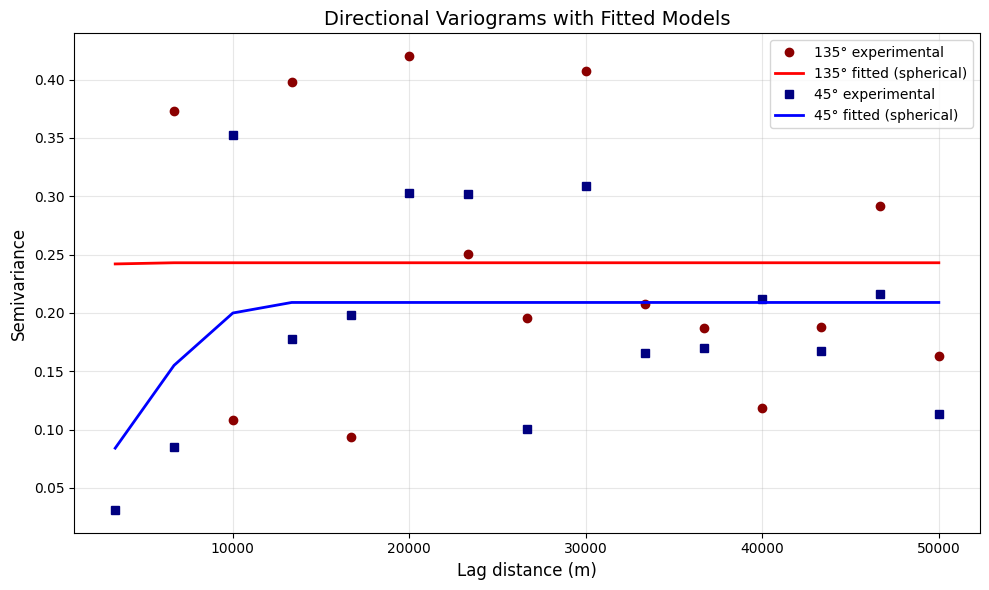


INTERPRETATION NOTES:
- Nugget = measurement error or micro-scale variation (y-intercept).
- Sill = the plateau value (total variance).
- Range = distance where correlation vanishes (model reaches sill).
- Effective range = ~95% sill — practical limit of spatial dependence.
- Compare 45° vs 135°: larger range → stronger spatial continuity in that direction.
- Difference in ranges indicates anisotropy (directional dependence of SOC).


In [11]:
## =========================================================
## Directional Variogram Analysis (Fixed for fitted_model)
## =========================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skgstat import DirectionalVariogram
import os

# =====================================
# 1. Load data
# =====================================
df = pd.read_csv('/Users/inesschwartz/Desktop/model/decluster_runs/decluster_run_001.csv')

coords = df[['X_coord', 'Y_coord']].values
values = df['log_soc_stock'].values

# =====================================
# 2. Define parameters
# =====================================
n_lags = 15
maxlag_km = 50       # max lag in km
maxlag = maxlag_km * 1000  # convert to meters if your coords are in meters
tolerance = 22.5
normalize = True
estimator = 'matheron'

# Directions (azimuths, in degrees)
dir1 = 135
dir2 = 45

# =====================================
# 3. Compute directional variograms
# =====================================
v135 = DirectionalVariogram(
    coordinates=coords,
    values=values,
    azimuth=dir1,
    n_lags=n_lags,
    maxlag=maxlag,
    tolerance=tolerance,
    normalize=normalize,
    estimator=estimator,
    model='spherical'   # you can change to 'exponential', 'gaussian', etc.
)

v45 = DirectionalVariogram(
    coordinates=coords,
    values=values,
    azimuth=dir2,
    n_lags=n_lags,
    maxlag=maxlag,
    tolerance=tolerance,
    normalize=normalize,
    estimator=estimator,
    model='spherical'
)

# =====================================
# 4. Describe function (fixed)
# =====================================
def describe_variogram(v, label):
    nugget, sill, rng = v.parameters
    sill_total = nugget + sill

    # Compute effective range (lag where model reaches 95% of sill)
    lags = np.linspace(0, rng * 2, 500)
    semivar_values = v.transform(lags)
    eff_idx = np.argmin(np.abs(semivar_values - 0.95 * sill_total))
    eff_range = lags[eff_idx]

    print(f"\n=== Direction {label}° ===")
    print(f"Model type: {v.model.__name__}")
    print(f"Nugget: {nugget:.4f}")
    print(f"Sill: {sill:.4f}")
    print(f"Range: {rng:.2f} m ({rng/1000:.2f} km)")
    print(f"Effective range (~95% sill): {eff_range:.2f} m ({eff_range/1000:.2f} km)")
    print(f"Number of lags: {len(v.bins)}")
    print(f"Mean lag distance: {np.mean(v.bins):.2f} m")
    print(f"Min/Max semivariance: {np.min(v.experimental):.4f} / {np.max(v.experimental):.4f}")

describe_variogram(v135, dir1)
describe_variogram(v45, dir2)

# =====================================
# 5. Plot results with fitted models (fixed)
# =====================================
plt.figure(figsize=(10,6))

# 135° direction
plt.plot(v135.bins, v135.experimental, 'o', color='darkred', label='135° experimental')
plt.plot(v135.bins, v135.fitted_model(v135.bins), '-', color='red', lw=2, label='135° fitted (spherical)')

# 45° direction
plt.plot(v45.bins, v45.experimental, 's', color='navy', label='45° experimental')
plt.plot(v45.bins, v45.fitted_model(v45.bins), '-', color='blue', lw=2, label='45° fitted (spherical)')

plt.xlabel('Lag distance (m)', fontsize=12)
plt.ylabel('Semivariance', fontsize=12)
plt.title('Directional Variograms with Fitted Models', fontsize=14)
plt.legend(fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# =====================================
# 6. Interpretation summary
# =====================================
print("\nINTERPRETATION NOTES:")
print("- Nugget = measurement error or micro-scale variation (y-intercept).")
print("- Sill = the plateau value (total variance).")
print("- Range = distance where correlation vanishes (model reaches sill).")
print("- Effective range = ~95% sill — practical limit of spatial dependence.")
print("- Compare 45° vs 135°: larger range → stronger spatial continuity in that direction.")
print("- Difference in ranges indicates anisotropy (directional dependence of SOC).")


In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv("/Volumes/One_Touch/angola_soils_thesis/GIS_Angola/tables/train_with_soc_MgCha.csv") 

min_val = df["soc_stock_MgCha"].min()
max_val = df["soc_stock_MgCha"].max()
print(f"🔹 soc_stock_MgCha range: {min_val:.2f} to {max_val:.2f}")


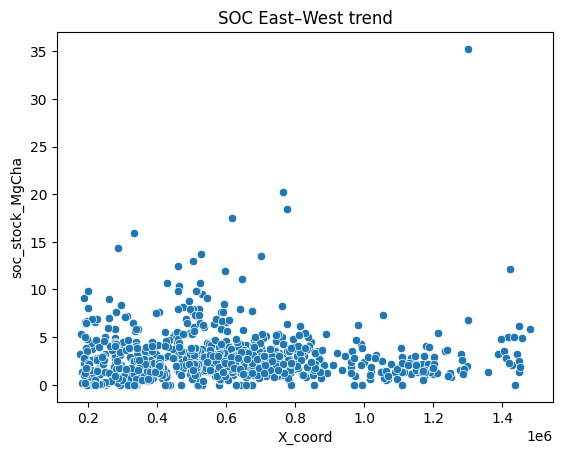

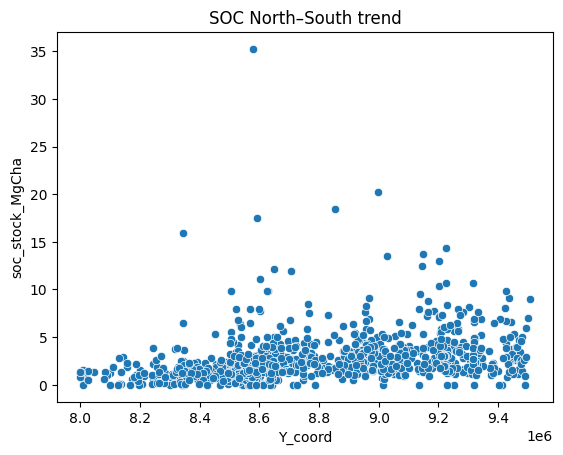

In [2]:
## visualize trends (directional bias)

import seaborn as sns
import matplotlib.pyplot as plt

sns.scatterplot(x="X_coord", y="soc_stock_MgCha", data=df)
plt.title("SOC East–West trend")
plt.show()

sns.scatterplot(x="Y_coord", y="soc_stock_MgCha", data=df)
plt.title("SOC North–South trend")
plt.show()



X_coord trend:
  slope = 0.000000 Mg C ha⁻¹ per meter
  r = 0.024,  p = 0.472


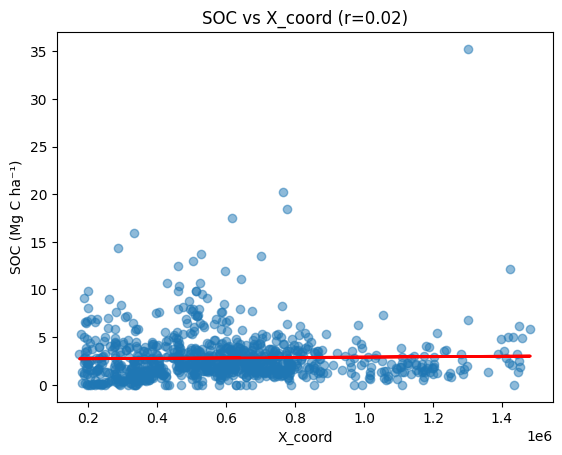


Y_coord trend:
  slope = 0.000002 Mg C ha⁻¹ per meter
  r = 0.295,  p = 0.000


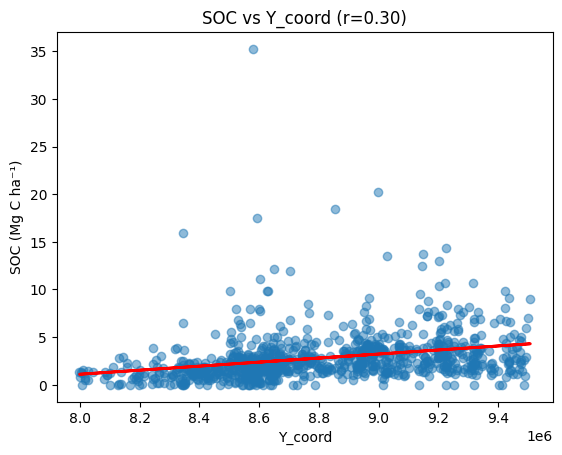

In [3]:
## comput trend lines

from scipy.stats import linregress
import matplotlib.pyplot as plt

for axis in ["X_coord", "Y_coord"]:
    slope, intercept, r, p, stderr = linregress(df[axis], df["soc_stock_MgCha"])
    print(f"\n{axis} trend:")
    print(f"  slope = {slope:.6f} Mg C ha⁻¹ per meter")
    print(f"  r = {r:.3f},  p = {p:.3f}")
    
    # Plot with fitted line
    plt.figure()
    plt.scatter(df[axis], df["soc_stock_MgCha"], alpha=0.5)
    plt.plot(
        df[axis],
        intercept + slope * df[axis],
        color="red", lw=2
    )
    plt.title(f"SOC vs {axis} (r={r:.2f})")
    plt.xlabel(axis)
    plt.ylabel("SOC (Mg C ha⁻¹)")
    plt.show()


## parameters on just a decluster of dataset

🔹 log_soc_stock range: 0.00 to 3.59

X_coord trend:
  slope = 0.000000 Mg C ha⁻¹ per meter
  r = 0.084,  p = 0.036


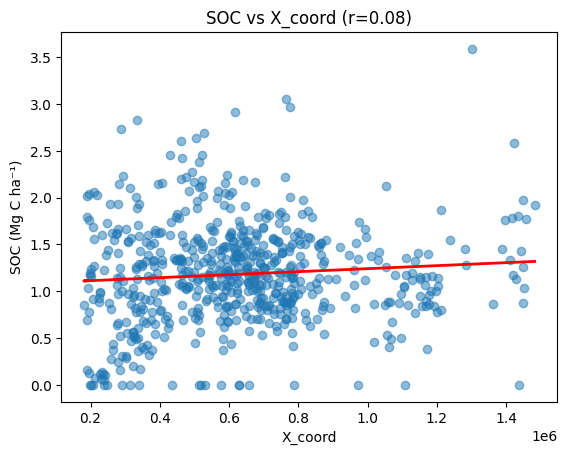


Y_coord trend:
  slope = 0.000001 Mg C ha⁻¹ per meter
  r = 0.387,  p = 0.000


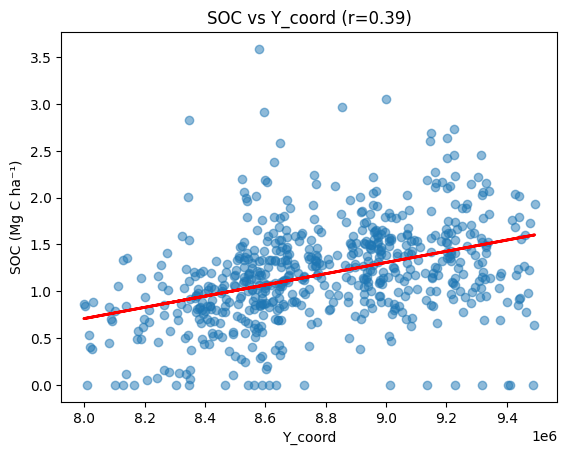

In [4]:
## on just a decluster

import pandas as pd
import numpy as np

df_decluster = pd.read_csv("/Users/inesschwartz/Desktop/model/decluster_runs/decluster_run_010.csv") 

min_val = df_decluster["log_soc_stock"].min()
max_val = df_decluster["log_soc_stock"].max()
print(f"🔹 log_soc_stock range: {min_val:.2f} to {max_val:.2f}")

## comput trend lines

from scipy.stats import linregress
import matplotlib.pyplot as plt

for axis in ["X_coord", "Y_coord"]:
    slope, intercept, r, p, stderr = linregress(df_decluster[axis], df_decluster["log_soc_stock"])
    print(f"\n{axis} trend:")
    print(f"  slope = {slope:.6f} Mg C ha⁻¹ per meter")
    print(f"  r = {r:.3f},  p = {p:.3f}")
    
    # Plot with fitted line
    plt.figure()
    plt.scatter(df_decluster[axis], df_decluster["log_soc_stock"], alpha=0.5)
    plt.plot(
        df_decluster[axis],
        intercept + slope * df_decluster[axis],
        color="red", lw=2
    )
    plt.title(f"SOC vs {axis} (r={r:.2f})")
    plt.xlabel(axis)
    plt.ylabel("SOC (Mg C ha⁻¹)")
    plt.show()


Max interpoint distance ~ 1763.7 km

Omnidirectional describe():
  model: gaussian
  estimator: cressie
  dist_func: euclidean
  normalized_effective_range: 777693207226.6542
  normalized_sill: 0.051862077383928736
  normalized_nugget: 0.054410999165117456
  effective_range: 881869.1553870424
  sill: 0.14992659404139175
  nugget: 0.15729519901073233
  params: {'estimator': 'cressie', 'model': 'gaussian', 'dist_func': 'euclidean', 'bin_func': 'even', 'normalize': False, 'fit_method': 'trf', 'fit_sigma': None, 'use_nugget': True, 'maxlag': 881873.063119735, 'n_lags': 15, 'verbose': False}
  kwargs: {}

Estimated ranges:
  Model effective_range: 881869 m
  95% experimental sill reach: 58791 m
  Distance where rho(h) <= 0.05: 58791 m


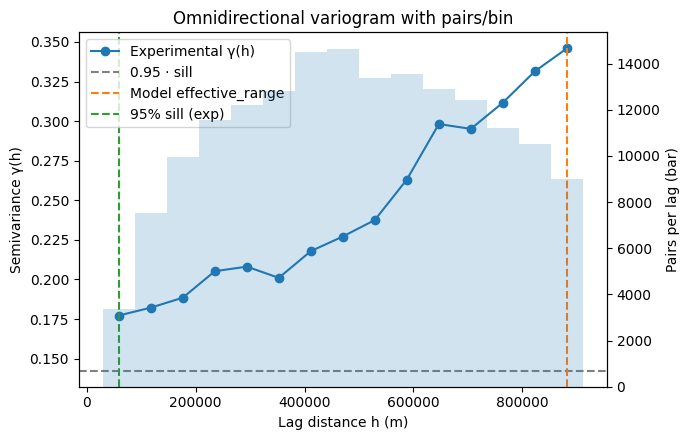


Directional summary:
 dir_deg  range_model_m     sill   nugget  range_95exp_m
       0  881869.155391 0.171146 0.133444   58791.277026
      45  881869.155391 0.171146 0.133444   58791.277026
      90  881869.155391 0.171146 0.133444   58791.277026
     135  881869.155391 0.171146 0.133444   58791.277026


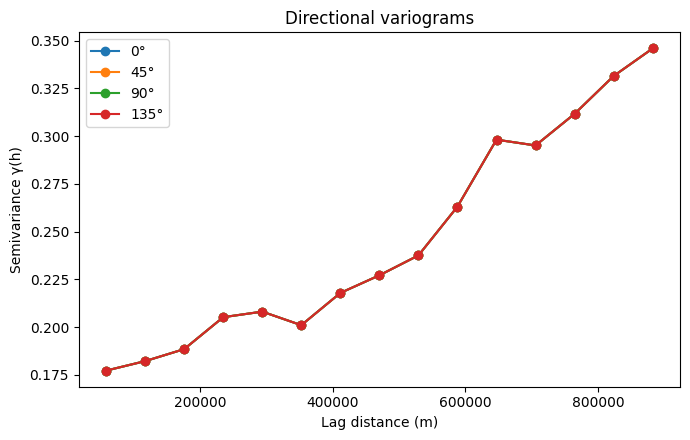


Anisotropy:
  Major direction (largest range): 0°
  Minor direction (smallest range): 0°
  Anisotropy ratio (minor/major): 1.00


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist
from skgstat import Variogram

# ----- INPUTS -----

coords = df_decluster[['X_coord','Y_coord']].values
z = df_decluster['log_soc_stock'].values

# ----- A) Interpoint distance domain -----
# max interpoint distance (to guide maxlag)
Dmax = pdist(coords).max()
print(f"Max interpoint distance ~ {Dmax/1000:.1f} km")

# Good starting choices:
n_lags   = 15
maxlag   = 0.5 * Dmax   # often 0.4–0.7 * Dmax is sensible
estimator = 'cressie'   # robust estimator (Cressie-Hawkins)

# ----- B) Omnidirectional variogram -----
V = Variogram(
    coords, z,
    n_lags=n_lags,
    maxlag=maxlag,
    use_nugget=True,
    normalize=False,
    estimator=estimator,
    model='gaussian'   # try 'exponential'/'gaussian' too
)

# Experimental info
bins = np.array(V.bins)                 # lag centers
gamma = np.array(V.experimental)        # semivariance per lag
pairs = np.array(V.bin_count)           # number of point pairs per lag

# --- Reconstruct approximate bin edges if missing ---
# Midpoints between adjacent bins, with extrapolated first/last edges
if len(bins) > 1:
    step = np.diff(bins).mean()
    edges = np.concatenate(([bins[0] - step/2], bins + step/2))
else:
    edges = np.array([0, bins[0]*2])

desc = V.describe()

print("\nOmnidirectional describe():")
for k,v in desc.items():
    print(f"  {k}: {v}")

# Sill (from model fit) and 95% sill rule
sill = desc['sill']
nugget = desc['nugget']
eff_range_model = desc['effective_range']  # model-derived

# 95% sill threshold in experimental curve
thr = 0.95 * sill
idx95 = np.where(gamma >= thr)[0]
eff_range_95 = bins[idx95[0]] if idx95.size else np.nan

print(f"\nEstimated ranges:")
print(f"  Model effective_range: {eff_range_model:.0f} m")
print(f"  95% experimental sill reach: {eff_range_95:.0f} m")

# Where is correlation strongest? (convert semivariogram to correlation proxy)
# rho(h) ≈ 1 - gamma(h)/sill  (bounded; crude but useful)
rho = 1 - gamma / sill
# First lag where rho drops below, say, 0.05 (≈ correlation gone)
idx_rho = np.where(rho <= 0.05)[0]
corr_dieoff = bins[idx_rho[0]] if idx_rho.size else np.nan
print(f"  Distance where rho(h) <= 0.05: {corr_dieoff:.0f} m")

# Plot with pairs/bin for trust
fig, ax1 = plt.subplots(figsize=(7,4.5))
ax1.plot(bins, gamma, 'o-', label='Experimental γ(h)')
ax1.axhline(thr, ls='--', color='gray', label='0.95 · sill')
ax1.axvline(eff_range_model, ls='--', color='tab:orange', label='Model effective_range')
if not np.isnan(eff_range_95):
    ax1.axvline(eff_range_95, ls='--', color='tab:green', label='95% sill (exp)')
ax1.set_xlabel('Lag distance h (m)')
ax1.set_ylabel('Semivariance γ(h)')
ax1.legend(loc='best')

ax2 = ax1.twinx()
ax2.bar(bins, pairs, width=(edges[1:]-edges[:-1]), alpha=0.2, align='center')
ax2.set_ylabel('Pairs per lag (bar)')
plt.title('Omnidirectional variogram with pairs/bin')
plt.tight_layout()
plt.show()

# ----- C) Directional variograms to confirm anisotropy -----
dirs = [0, 45, 90, 135]  # degrees (0 = E–W, 90 = N–S)
results = []

for d in dirs:
    Vd = Variogram(
        coords, z,
        n_lags=n_lags, maxlag=maxlag,
        use_nugget=True, normalize=False,
        estimator=estimator,
        model='spherical',
        direction=d, tolerance=22.5  # ±22.5° sector
    )
    descd = Vd.describe()
    sill_d = descd['sill']
    bins_d = Vd.bins
    gamma_d = Vd.experimental
    # Experimental 95% sill reach
    thr_d = 0.95 * sill_d
    idx95_d = np.where(gamma_d >= thr_d)[0]
    eff95_d = bins_d[idx95_d[0]] if idx95_d.size else np.nan

    results.append({
        'dir_deg': d,
        'range_model_m': descd['effective_range'],
        'sill': sill_d,
        'nugget': descd['nugget'],
        'range_95exp_m': eff95_d
    })

# Tabulate
res_df = pd.DataFrame(results).sort_values('dir_deg')
print("\nDirectional summary:")
print(res_df.to_string(index=False))

# Quick comparison plot
plt.figure(figsize=(7,4.5))
for d in dirs:
    Vd = Variogram(
        coords, z,
        n_lags=n_lags, maxlag=maxlag,
        use_nugget=True, normalize=False,
        estimator=estimator,
        model='spherical',
        direction=d, tolerance=22.5
    )
    plt.plot(Vd.bins, Vd.experimental, 'o-', label=f'{d}°')
plt.xlabel('Lag distance (m)')
plt.ylabel('Semivariance γ(h)')
plt.title('Directional variograms')
plt.legend()
plt.tight_layout()
plt.show()

# ----- D) Anisotropy metrics -----
# Major/minor ranges and ratio
major_dir = res_df.loc[res_df['range_model_m'].idxmax(), 'dir_deg']
minor_dir = res_df.loc[res_df['range_model_m'].idxmin(), 'dir_deg']
anis_ratio = res_df['range_model_m'].min() / res_df['range_model_m'].max()

print(f"\nAnisotropy:")
print(f"  Major direction (largest range): {major_dir}°")
print(f"  Minor direction (smallest range): {minor_dir}°")
print(f"  Anisotropy ratio (minor/major): {anis_ratio:.2f}")


## parameters on full dataset

Max interpoint distance ~ 1822.8 km

Omnidirectional describe():
  model: spherical
  estimator: cressie
  dist_func: euclidean
  normalized_effective_range: 830635183363.5258
  normalized_sill: 7.372583782386768
  normalized_nugget: 8.969034125474737
  effective_range: 911391.8934045472
  sill: 1.758051905646587
  nugget: 2.1387383312984825
  params: {'estimator': 'cressie', 'model': 'spherical', 'dist_func': 'euclidean', 'bin_func': 'even', 'normalize': False, 'fit_method': 'trf', 'fit_sigma': None, 'use_nugget': True, 'maxlag': 911393.7711615261, 'n_lags': 15, 'verbose': False}
  kwargs: {}

Estimated ranges:
  Model effective_range: 911392 m
  95% experimental sill reach: 60759 m
  Distance where rho(h) <= 0.05: 60759 m


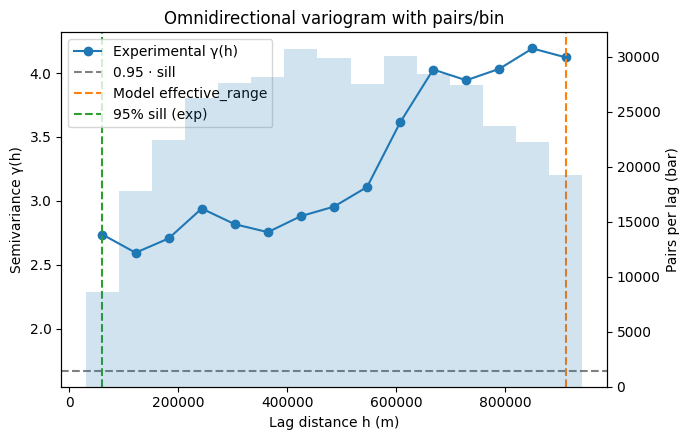


Directional summary:
 dir_deg  range_model_m     sill   nugget  range_95exp_m
       0  911391.893405 1.758052 2.138738    60759.45956
      45  911391.893405 1.758052 2.138738    60759.45956
      90  911391.893405 1.758052 2.138738    60759.45956
     135  911391.893405 1.758052 2.138738    60759.45956


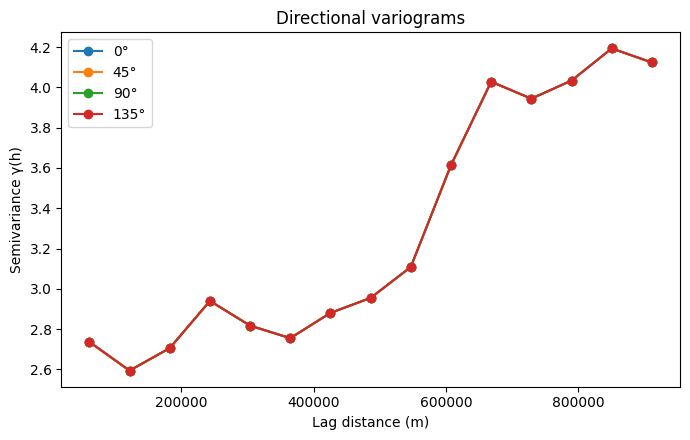


Anisotropy:
  Major direction (largest range): 0°
  Minor direction (smallest range): 0°
  Anisotropy ratio (minor/major): 1.00


In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist
from skgstat import Variogram

# ----- INPUTS -----

coords = df[['X_coord','Y_coord']].values
z = df['soc_stock_MgCha'].values

# ----- A) Interpoint distance domain -----
# max interpoint distance (to guide maxlag)
Dmax = pdist(coords).max()
print(f"Max interpoint distance ~ {Dmax/1000:.1f} km")

# Good starting choices:
n_lags   = 15
maxlag   = 0.5 * Dmax   # often 0.4–0.7 * Dmax is sensible
estimator = 'cressie'   # robust estimator (Cressie-Hawkins)

# ----- B) Omnidirectional variogram -----
V = Variogram(
    coords, z,
    n_lags=n_lags,
    maxlag=maxlag,
    use_nugget=True,
    normalize=False,
    estimator=estimator,
    model='spherical'   # try 'exponential'/'gaussian' too
)

# Experimental info
bins = np.array(V.bins)                 # lag centers
gamma = np.array(V.experimental)        # semivariance per lag
pairs = np.array(V.bin_count)           # number of point pairs per lag

# --- Reconstruct approximate bin edges if missing ---
# Midpoints between adjacent bins, with extrapolated first/last edges
if len(bins) > 1:
    step = np.diff(bins).mean()
    edges = np.concatenate(([bins[0] - step/2], bins + step/2))
else:
    edges = np.array([0, bins[0]*2])

desc = V.describe()

print("\nOmnidirectional describe():")
for k,v in desc.items():
    print(f"  {k}: {v}")

# Sill (from model fit) and 95% sill rule
sill = desc['sill']
nugget = desc['nugget']
eff_range_model = desc['effective_range']  # model-derived

# 95% sill threshold in experimental curve
thr = 0.95 * sill
idx95 = np.where(gamma >= thr)[0]
eff_range_95 = bins[idx95[0]] if idx95.size else np.nan

print(f"\nEstimated ranges:")
print(f"  Model effective_range: {eff_range_model:.0f} m")
print(f"  95% experimental sill reach: {eff_range_95:.0f} m")

# Where is correlation strongest? (convert semivariogram to correlation proxy)
# rho(h) ≈ 1 - gamma(h)/sill  (bounded; crude but useful)
rho = 1 - gamma / sill
# First lag where rho drops below, say, 0.05 (≈ correlation gone)
idx_rho = np.where(rho <= 0.05)[0]
corr_dieoff = bins[idx_rho[0]] if idx_rho.size else np.nan
print(f"  Distance where rho(h) <= 0.05: {corr_dieoff:.0f} m")

# Plot with pairs/bin for trust
fig, ax1 = plt.subplots(figsize=(7,4.5))
ax1.plot(bins, gamma, 'o-', label='Experimental γ(h)')
ax1.axhline(thr, ls='--', color='gray', label='0.95 · sill')
ax1.axvline(eff_range_model, ls='--', color='tab:orange', label='Model effective_range')
if not np.isnan(eff_range_95):
    ax1.axvline(eff_range_95, ls='--', color='tab:green', label='95% sill (exp)')
ax1.set_xlabel('Lag distance h (m)')
ax1.set_ylabel('Semivariance γ(h)')
ax1.legend(loc='best')

ax2 = ax1.twinx()
ax2.bar(bins, pairs, width=(edges[1:]-edges[:-1]), alpha=0.2, align='center')
ax2.set_ylabel('Pairs per lag (bar)')
plt.title('Omnidirectional variogram with pairs/bin')
plt.tight_layout()
plt.show()

# ----- C) Directional variograms to confirm anisotropy -----
dirs = [0, 45, 90, 135]  # degrees (0 = E–W, 90 = N–S)
results = []

for d in dirs:
    Vd = Variogram(
        coords, z,
        n_lags=n_lags, maxlag=maxlag,
        use_nugget=True, normalize=False,
        estimator=estimator,
        model='spherical',
        direction=d, tolerance=22.5  # ±22.5° sector
    )
    descd = Vd.describe()
    sill_d = descd['sill']
    bins_d = Vd.bins
    gamma_d = Vd.experimental
    # Experimental 95% sill reach
    thr_d = 0.95 * sill_d
    idx95_d = np.where(gamma_d >= thr_d)[0]
    eff95_d = bins_d[idx95_d[0]] if idx95_d.size else np.nan

    results.append({
        'dir_deg': d,
        'range_model_m': descd['effective_range'],
        'sill': sill_d,
        'nugget': descd['nugget'],
        'range_95exp_m': eff95_d
    })

# Tabulate
res_df = pd.DataFrame(results).sort_values('dir_deg')
print("\nDirectional summary:")
print(res_df.to_string(index=False))

# Quick comparison plot
plt.figure(figsize=(7,4.5))
for d in dirs:
    Vd = Variogram(
        coords, z,
        n_lags=n_lags, maxlag=maxlag,
        use_nugget=True, normalize=False,
        estimator=estimator,
        model='spherical',
        direction=d, tolerance=22.5
    )
    plt.plot(Vd.bins, Vd.experimental, 'o-', label=f'{d}°')
plt.xlabel('Lag distance (m)')
plt.ylabel('Semivariance γ(h)')
plt.title('Directional variograms')
plt.legend()
plt.tight_layout()
plt.show()

# ----- D) Anisotropy metrics -----
# Major/minor ranges and ratio
major_dir = res_df.loc[res_df['range_model_m'].idxmax(), 'dir_deg']
minor_dir = res_df.loc[res_df['range_model_m'].idxmin(), 'dir_deg']
anis_ratio = res_df['range_model_m'].min() / res_df['range_model_m'].max()

print(f"\nAnisotropy:")
print(f"  Major direction (largest range): {major_dir}°")
print(f"  Minor direction (smallest range): {minor_dir}°")
print(f"  Anisotropy ratio (minor/major): {anis_ratio:.2f}")


In [15]:
## parameters per decluster subset (1-5)

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skgstat import DirectionalVariogram
from scipy.spatial.distance import pdist

# --- Paths ---
decluster_dir = "/Users/inesschwartz/Desktop/model/decluster_runs"
out_summary_csv = os.path.join(decluster_dir, "variogram_summary_fixed.csv")

# --- Parameters ---
directions = [0, 45, 90, 135]   # degrees (azimuths)
tol = 22.5                      # half-angle tolerance
n_lags = 15
maxlag_fraction = 0.2 #changed from .5
estimator = "cressie"
model_type = "spherical"

summary = []

# --- Loop through declusters ---
for i in range(1, 6):
    subset_name = f"decluster_run_{i:03d}.csv"
    subset_path = os.path.join(decluster_dir, subset_name)
    if not os.path.exists(subset_path):
        print(f"⚠️ File not found: {subset_name}, skipping.")
        continue

    df = pd.read_csv(subset_path)
    print(f"\n📂 Processing {subset_name} — n={len(df)} samples")

    # Ensure required columns exist
    if not {"X_coord", "Y_coord", "log_soc_stock"}.issubset(df.columns):
        print(f"❌ Missing columns in {subset_name}, skipping.")
        continue

    coords = df[["X_coord", "Y_coord"]].values
    values = df["log_soc_stock"].values

    maxdist = pdist(coords).max()
    maxlag = maxlag_fraction * maxdist

    for d in directions:
        # Compute directional variogram
        V = DirectionalVariogram(
            coordinates=coords,
            values=values,
            azimuth=d,
            tolerance=tol,
            n_lags=n_lags,
            maxlag=maxlag,
            model=model_type,
            use_nugget=True,
            estimator=estimator,
            normalize=False,
        )

        desc = V.describe()
        summary.append({
            "decluster_run": subset_name,
            "direction_deg": d,
            "range_m": desc.get("effective_range", np.nan),
            "sill": desc.get("sill", np.nan),
            "nugget": desc.get("nugget", np.nan),
            "n_lags": n_lags,
            "maxlag_m": maxlag,
            "model": model_type
        })

        # Optional plot
        plt.plot(V.bins, V.experimental, "o-", label=f"{d}°")
        plt.xlabel("Lag distance (m)")
        plt.ylabel("Semivariance γ(h)")
        plt.title(f"{subset_name} — Direction {d}°")
        plt.legend()
        plt.tight_layout()
        out_plot = os.path.join(decluster_dir, f"vario_{subset_name[:-4]}_{d}deg.png")
        plt.savefig(out_plot, dpi=150)
        plt.close()

# --- Save results ---
summary_df = pd.DataFrame(summary)
summary_df.to_csv(out_summary_csv, index=False)
print(f"\n✅ Directional variogram summary saved to:\n{out_summary_csv}")



📂 Processing decluster_run_001.csv — n=631 samples

📂 Processing decluster_run_002.csv — n=631 samples

📂 Processing decluster_run_003.csv — n=631 samples

📂 Processing decluster_run_004.csv — n=631 samples

📂 Processing decluster_run_005.csv — n=631 samples

✅ Directional variogram summary saved to:
/Users/inesschwartz/Desktop/model/decluster_runs/variogram_summary_fixed.csv



Anisotropy summary:
           decluster_run  major_dir  minor_dir  major_range_km  \
0  decluster_run_001.csv        135         90      352.749225   
1  decluster_run_002.csv        135         90      352.749225   
2  decluster_run_003.csv        135         90      352.749225   
3  decluster_run_004.csv        135         90      352.749225   
4  decluster_run_005.csv        135         90      352.749225   

   minor_range_km  anisotropy_ratio  
0      352.749225               1.0  
1      352.749225               1.0  
2      352.749225               1.0  
3      352.749225               1.0  
4      352.749225               1.0  


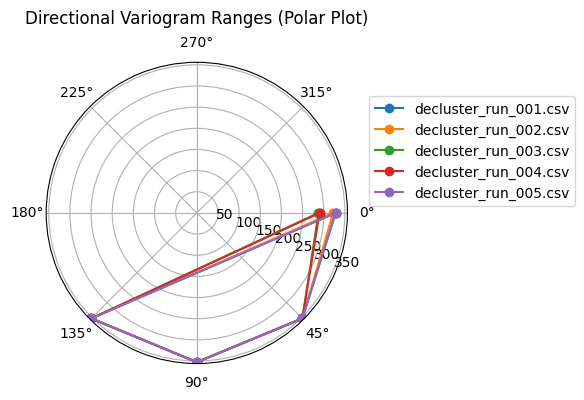

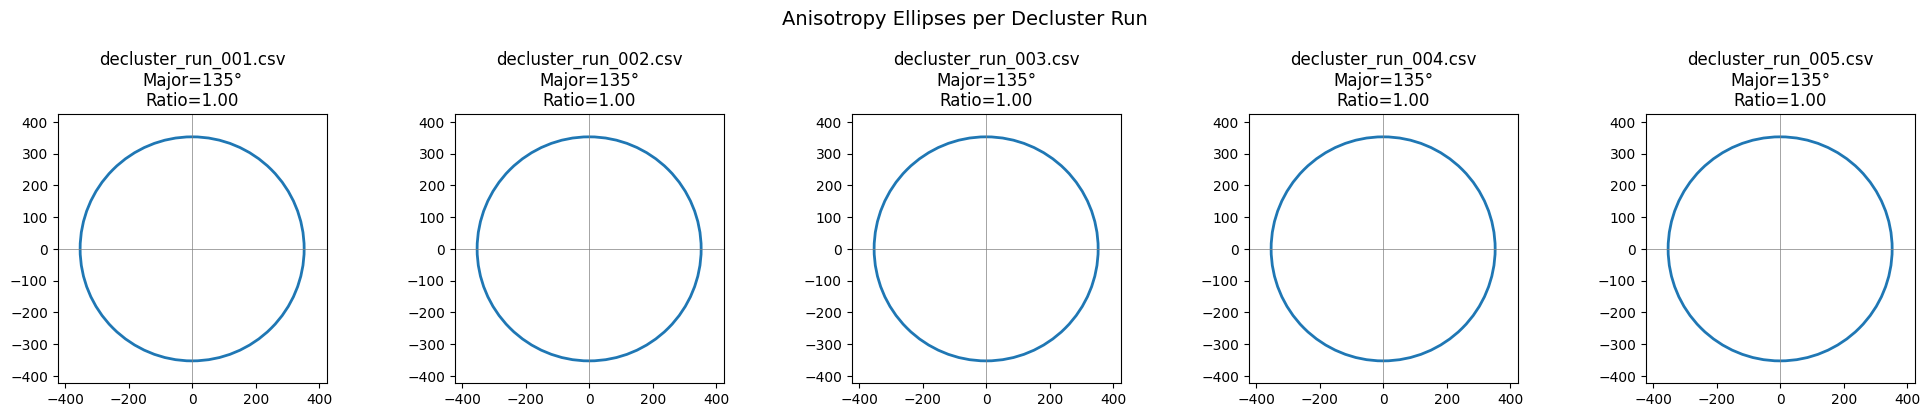

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

# --- Load data ---
df = pd.read_csv("/Users/inesschwartz/Desktop/model/decluster_runs/variogram_summary_fixed.csv")

# --- Clean up ---
df["direction_deg"] = df["direction_deg"].astype(int)
declusters = sorted(df["decluster_run"].unique())

# --- Compute summary ---
summary = []
for decl in declusters:
    sub = df[df["decluster_run"] == decl]
    if sub.empty:
        continue
    major_idx = sub["sill"].idxmax()
    minor_idx = sub["sill"].idxmin()
    major_dir = sub.loc[major_idx, "direction_deg"]
    minor_dir = sub.loc[minor_idx, "direction_deg"]
    major_range = sub.loc[major_idx, "range_m"]/1000
    minor_range = sub.loc[minor_idx, "range_m"]/1000
    anis_ratio = minor_range/major_range
    summary.append((decl, major_dir, minor_dir, major_range, minor_range, anis_ratio))

anis_df = pd.DataFrame(summary, columns=["decluster_run", "major_dir", "minor_dir", "major_range_km", "minor_range_km", "anisotropy_ratio"])
print("\nAnisotropy summary:")
print(anis_df)

# --- Polar plot of directional ranges ---
plt.figure(figsize=(6,6))
ax = plt.subplot(111, polar=True)
for decl in declusters:
    sub = df[df["decluster_run"] == decl].sort_values("direction_deg")
    angles = np.deg2rad(sub["direction_deg"].tolist() + [sub["direction_deg"].iloc[0]])
    ranges = (sub["range_m"]/1000).tolist() + [(sub["range_m"].iloc[0]/1000)]
    ax.plot(angles, ranges, 'o-', label=decl)
ax.set_theta_zero_location('E')
ax.set_theta_direction(-1)
ax.set_title("Directional Variogram Ranges (Polar Plot)", va='bottom')
ax.legend(loc="lower left", bbox_to_anchor=(1.05, 0.5))
plt.tight_layout()
plt.show()

# --- Anisotropy ellipses ---
fig, axes = plt.subplots(1, len(declusters), figsize=(4*len(declusters), 4), subplot_kw={'aspect': 'equal'})
for ax, decl in zip(axes, declusters):
    sub = anis_df[anis_df["decluster_run"] == decl]
    if sub.empty: continue
    major_dir = sub["major_dir"].iloc[0]
    major_range = sub["major_range_km"].iloc[0]
    minor_range = sub["minor_range_km"].iloc[0]
    ratio = sub["anisotropy_ratio"].iloc[0]
    ell = Ellipse((0,0), width=minor_range*2, height=major_range*2, angle=-major_dir, fill=False, edgecolor="tab:blue", lw=2)
    ax.add_patch(ell)
    ax.set_xlim(-major_range*1.2, major_range*1.2)
    ax.set_ylim(-major_range*1.2, major_range*1.2)
    ax.set_title(f"{decl}\nMajor={major_dir}°\nRatio={ratio:.2f}")
    ax.axhline(0, color="gray", lw=0.5)
    ax.axvline(0, color="gray", lw=0.5)
plt.suptitle("Anisotropy Ellipses per Decluster Run", fontsize=14)
plt.tight_layout(rect=[0,0,1,0.95])
plt.show()


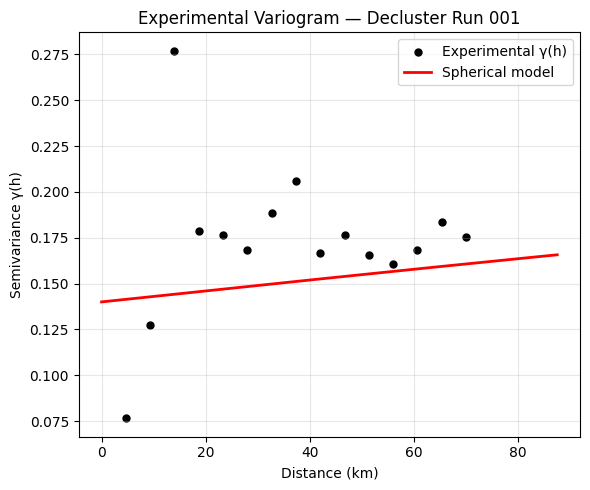

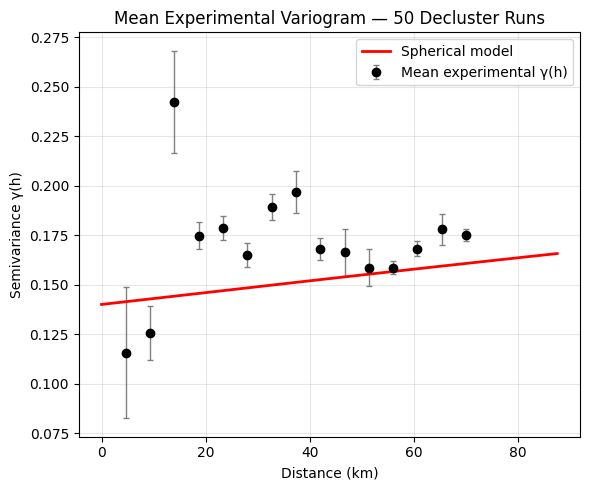

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skgstat import Variogram
import glob
import os

# --- Paths ---
decluster_dir = "/Users/inesschwartz/Desktop/model/decluster_runs"
decluster_files = sorted(glob.glob(os.path.join(decluster_dir, "decluster_run_*.csv")))

# --- Fixed variogram parameters (your stable model) ---
nugget = 0.14
sill = 0.07
var_range = 350000   # meters
azimuth = 135
anisotropy_ratio = 0.4
tolerance = 22.5

# --- Helper function to compute experimental variogram ---
def compute_variogram(file):
    df = pd.read_csv(file)
    coords = df[['X_coord', 'Y_coord']].values
    values = df['log_soc_stock'].values

    V = Variogram(
        coords,
        values,
        model='spherical',
        estimator='cressie',
        n_lags=15,
        maxlag=var_range * 0.2,  # analyze up to 70 km for SOC scale
        direction=azimuth,
        tolerance=tolerance,
        anisotropy_ratio=anisotropy_ratio,
        use_nugget=True,
        normalize=False,
    )
    # Override with your known model parameters
    V.variogram_model_parameters = [sill, var_range, nugget]
    return V

# =========================================================
# PLOT 1 — Experimental + model variogram for decluster 001
# =========================================================
decluster_example = os.path.join(decluster_dir, "decluster_run_001.csv")
V1 = compute_variogram(decluster_example)

plt.figure(figsize=(6, 5))
plt.scatter(V1.bins/1000, V1.experimental, color='black', s=25, label='Experimental γ(h)')
h = np.linspace(0, var_range * 0.25, 200)
gamma_model = np.where(
    h <= var_range,
    nugget + sill * (1.5*(h/var_range) - 0.5*(h/var_range)**3),
    nugget + sill
)
plt.plot(h/1000, gamma_model, color='red', lw=2, label='Spherical model')
plt.xlabel("Distance (km)")
plt.ylabel("Semivariance γ(h)")
plt.title("Experimental Variogram — Decluster Run 001")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# =========================================================
# PLOT 2 — Mean variogram (average of all 50 declusters)
# =========================================================
bin_centers = None
exp_values = []

for file in decluster_files:
    V = compute_variogram(file)
    if bin_centers is None:
        bin_centers = V.bins
    exp_values.append(V.experimental)

exp_values = np.array(exp_values)
mean_exp = np.nanmean(exp_values, axis=0)
std_exp = np.nanstd(exp_values, axis=0)

# --- Plot mean + standard deviation ---
plt.figure(figsize=(6,5))
plt.errorbar(bin_centers/1000, mean_exp, yerr=std_exp, fmt='o', color='black',
             ecolor='gray', elinewidth=1, capsize=2, label='Mean experimental γ(h)')
plt.plot(h/1000, gamma_model, color='red', lw=2, label='Spherical model')
plt.xlabel("Distance (km)")
plt.ylabel("Semivariance γ(h)")
plt.title("Mean Experimental Variogram — 50 Decluster Runs")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()



✅ Best-fit model: gaussian
  nugget = 0.000
  sill   = 0.181
  range  = 14206 m
  RSS    = 0.0060


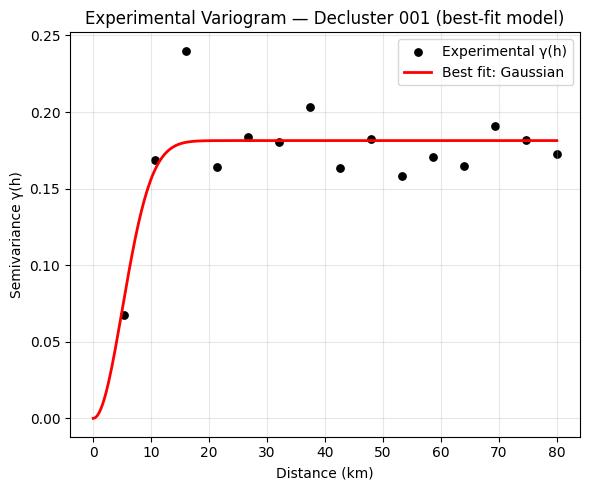

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skgstat import Variogram
import os

# --- Paths & inputs ---
decluster_001 = "/Users/inesschwartz/Desktop/model/decluster_runs/decluster_run_001.csv"

# --- directional/anisotropy parameters ---
azimuth = 135
anisotropy_ratio = 0.4
tolerance = 22.5
n_lags = 15
maxlag_km = 80          # km
maxlag = maxlag_km * 1000

# --- candidate models supported in your version ---
candidates = ['spherical', 'exponential', 'gaussian', 'matern']

# --- load data ---
df = pd.read_csv(decluster_001)
coords = df[['X_coord', 'Y_coord']].values
values = df['log_soc_stock'].values

fits = []
for m in candidates:
    try:
        V = Variogram(
            coordinates=coords,
            values=values,
            model=m,
            n_lags=n_lags,
            maxlag=maxlag,
            estimator='cressie',
            use_nugget=True,
            normalize=False,
            direction=azimuth,
            tolerance=tolerance,
            anisotropy_ratio=anisotropy_ratio,
        )

        # residuals between experimental and fitted
        y = np.array(V.experimental, dtype=float)
        x = np.array(V.bins, dtype=float)
        yhat = V.fitted_model(x)
        rss = np.nansum((y - yhat) ** 2)

        desc = V.describe()
        fits.append({
            'model': m,
            'variogram': V,
            'rss': rss,
            'range': desc.get('effective_range', np.nan),
            'sill': desc.get('sill', np.nan),
            'nugget': desc.get('nugget', np.nan)
        })
    except Exception as e:
        print(f"⚠️ Skipping {m}: {e}")

# --- choose best model ---
best = min(fits, key=lambda d: d['rss'])
Vbest = best['variogram']

print("\n✅ Best-fit model:", best['model'])
print(f"  nugget = {best['nugget']:.3f}")
print(f"  sill   = {best['sill']:.3f}")
print(f"  range  = {best['range']:.0f} m")
print(f"  RSS    = {best['rss']:.4f}")

# --- plot experimental + best model ---
plt.figure(figsize=(6, 5))
plt.scatter(np.array(Vbest.bins) / 1000, Vbest.experimental,
            color='k', s=28, label='Experimental γ(h)')

h = np.linspace(0, maxlag, 300)
plt.plot(h / 1000, Vbest.fitted_model(h), 'r-', lw=2,
         label=f'Best fit: {best["model"].capitalize()}')

plt.xlabel("Distance (km)")
plt.ylabel("Semivariance γ(h)")
plt.title("Experimental Variogram — Decluster 001 (best-fit model)")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()



📂 Processing decluster_run_001.csv ...


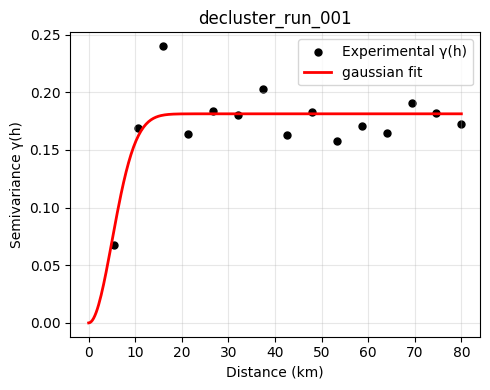


📂 Processing decluster_run_002.csv ...


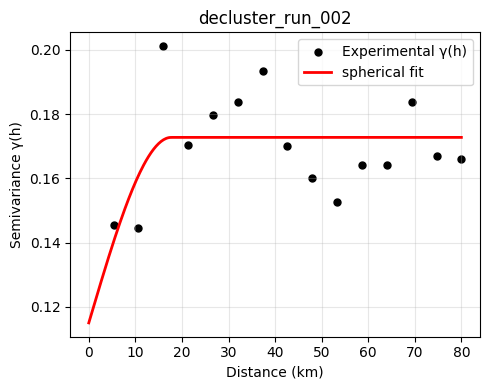


📂 Processing decluster_run_003.csv ...


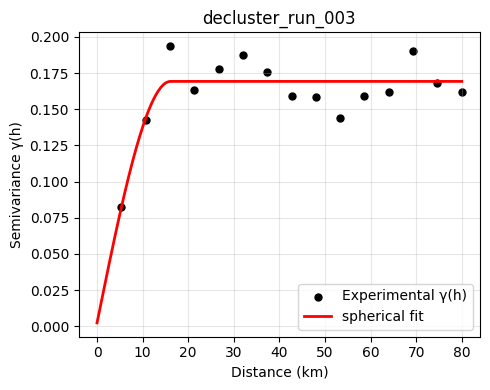


📂 Processing decluster_run_004.csv ...


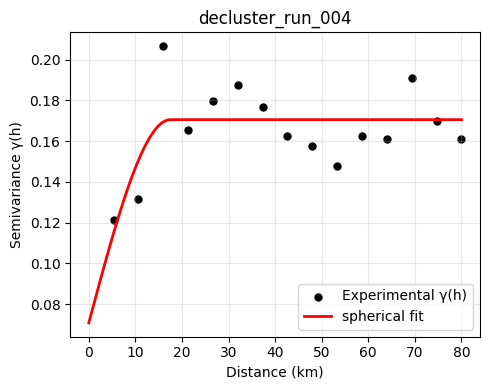


📂 Processing decluster_run_005.csv ...


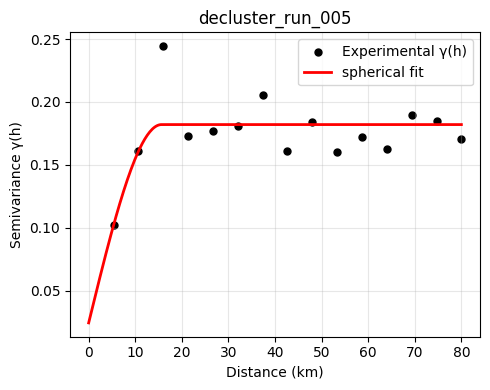


✅ Variogram summary saved to: /Users/inesschwartz/Desktop/model/decluster_runs/short_range_variogram_summary.csv
           decluster_run best_model       rss        nugget      sill  \
0  decluster_run_001.csv   gaussian  0.005967  2.185458e-19  0.181373   
1  decluster_run_002.csv  spherical  0.002676  1.150444e-01  0.057717   
2  decluster_run_003.csv  spherical  0.002603  2.317522e-03  0.166928   
3  decluster_run_004.csv  spherical  0.003630  7.072910e-02  0.099758   
4  decluster_run_005.csv  spherical  0.006127  2.449448e-02  0.157554   

        range_m  
0  14206.138161  
1  17703.861366  
2  16132.715826  
3  17524.494246  
4  15640.185445  


In [10]:
## comparing 1-5 resuls

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skgstat import Variogram
import glob, os

# --- Paths ---
decluster_dir = "/Users/inesschwartz/Desktop/model/decluster_runs"
decluster_files = sorted(glob.glob(os.path.join(decluster_dir, "decluster_run_00*.csv")))

# --- Parameters ---
azimuth = 135
anisotropy_ratio = 0.4
tolerance = 22.5
n_lags = 15
maxlag_km = 80          # up to 80 km
maxlag = maxlag_km * 1000
candidates = ['spherical', 'exponential', 'gaussian', 'matern']

results = []

# --- Loop through first few declusters (adjust number here) ---
for file in decluster_files[:5]:
    print(f"\n📂 Processing {os.path.basename(file)} ...")
    df = pd.read_csv(file)
    coords = df[['X_coord', 'Y_coord']].values
    values = df['log_soc_stock'].values

    fits = []
    for m in candidates:
        try:
            V = Variogram(
                coords, values,
                model=m,
                n_lags=n_lags,
                maxlag=maxlag,
                estimator='cressie',
                use_nugget=True,
                normalize=False,
                direction=azimuth,
                tolerance=tolerance,
                anisotropy_ratio=anisotropy_ratio
            )
            y = np.array(V.experimental, dtype=float)
            x = np.array(V.bins, dtype=float)
            yhat = V.fitted_model(x)
            rss = np.nansum((y - yhat) ** 2)
            desc = V.describe()
            fits.append({
                'model': m,
                'V': V,
                'rss': rss,
                'nugget': desc.get('nugget', np.nan),
                'sill': desc.get('sill', np.nan),
                'range': desc.get('effective_range', np.nan)
            })
        except Exception as e:
            print(f"⚠️ Skipping {m}: {e}")
            continue

    # choose best model by lowest RSS
    best = min(fits, key=lambda d: d['rss'])
    results.append({
        'decluster_run': os.path.basename(file),
        'best_model': best['model'],
        'rss': best['rss'],
        'nugget': best['nugget'],
        'sill': best['sill'],
        'range_m': best['range']
    })

    # --- Plot each best-fit ---
    Vb = best['V']
    plt.figure(figsize=(5,4))
    plt.scatter(Vb.bins/1000, Vb.experimental, color='k', s=25, label='Experimental γ(h)')
    h = np.linspace(0, maxlag, 300)
    plt.plot(h/1000, Vb.fitted_model(h), 'r-', lw=2, label=f'{best["model"]} fit')
    plt.xlabel("Distance (km)")
    plt.ylabel("Semivariance γ(h)")
    plt.title(os.path.basename(file).replace('.csv',''))
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

# --- Summarize results ---
summary_df = pd.DataFrame(results)
summary_csv = os.path.join(decluster_dir, "short_range_variogram_summary.csv")
summary_df.to_csv(summary_csv, index=False)
print("\n✅ Variogram summary saved to:", summary_csv)
print(summary_df)



✅ Variogram summary saved: /Users/inesschwartz/Desktop/model/decluster_runs/variogram_short_range_summary_all.csv
                 range_m                   sill                  nugget  \
                    mean          std      mean       std          mean   
best_model                                                                
gaussian    13678.159739   840.807550  0.181031  0.001981  2.601569e-14   
spherical   16980.946256  1198.309323  0.118329  0.039783  5.577274e-02   

                          
                     std  
best_model                
gaussian    1.007638e-13  
spherical   3.643374e-02  


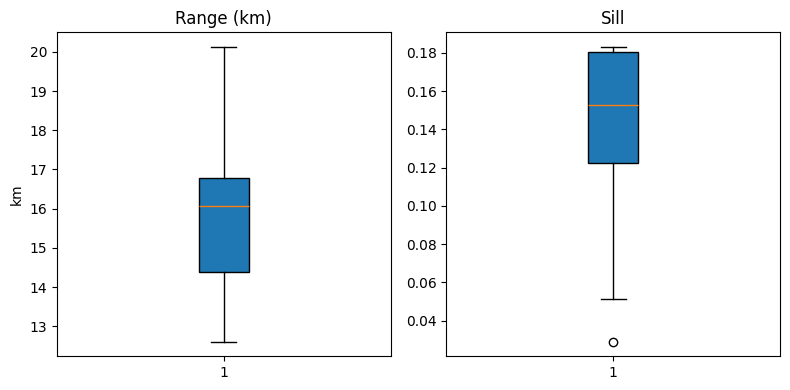

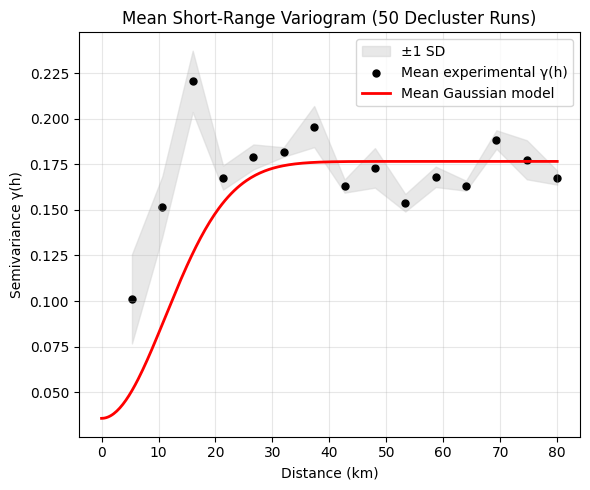

In [11]:
## testing OK on all declusters to make sure average small scale process fits all

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skgstat import Variogram
import glob, os

# --- Paths ---
decluster_dir = "/Users/inesschwartz/Desktop/model/decluster_runs"
decluster_files = sorted(glob.glob(os.path.join(decluster_dir, "decluster_run_*.csv")))

# --- Parameters ---
azimuth = 135
anisotropy_ratio = 0.4
tolerance = 22.5
n_lags = 15
maxlag_km = 80
maxlag = maxlag_km * 1000
candidates = ['spherical', 'exponential', 'gaussian', 'matern']

results = []
exp_values = []
bin_centers = None

# --- Loop over declusters ---
for file in decluster_files:
    df = pd.read_csv(file)
    coords = df[['X_coord', 'Y_coord']].values
    values = df['log_soc_stock'].values

    fits = []
    for m in candidates:
        try:
            V = Variogram(
                coords, values,
                model=m,
                n_lags=n_lags,
                maxlag=maxlag,
                estimator='cressie',
                use_nugget=True,
                normalize=False,
                direction=azimuth,
                tolerance=tolerance,
                anisotropy_ratio=anisotropy_ratio
            )
            y = np.array(V.experimental, dtype=float)
            x = np.array(V.bins, dtype=float)
            yhat = V.fitted_model(x)
            rss = np.nansum((y - yhat) ** 2)
            desc = V.describe()
            fits.append({
                'model': m,
                'V': V,
                'rss': rss,
                'nugget': desc.get('nugget', np.nan),
                'sill': desc.get('sill', np.nan),
                'range': desc.get('effective_range', np.nan)
            })
        except Exception as e:
            print(f"⚠️ Skipping {m}: {e}")
            continue

    if not fits:
        continue
    best = min(fits, key=lambda d: d['rss'])
    Vb = best['V']
    results.append({
        'decluster_run': os.path.basename(file),
        'best_model': best['model'],
        'rss': best['rss'],
        'nugget': best['nugget'],
        'sill': best['sill'],
        'range_m': best['range']
    })

    # Store experimental γ(h)
    if bin_centers is None:
        bin_centers = Vb.bins
    exp_values.append(Vb.experimental)

# --- Summaries ---
summary_df = pd.DataFrame(results)
summary_path = os.path.join(decluster_dir, "variogram_short_range_summary_all.csv")
summary_df.to_csv(summary_path, index=False)
print("\n✅ Variogram summary saved:", summary_path)
print(summary_df.groupby('best_model')[['range_m','sill','nugget']].agg(['mean','std']))

# --- Boxplots for visual stability ---
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.boxplot(summary_df['range_m']/1000, patch_artist=True)
plt.title("Range (km)")
plt.ylabel("km")
plt.subplot(1,2,2)
plt.boxplot(summary_df['sill'], patch_artist=True)
plt.title("Sill")
plt.tight_layout()
plt.show()

# --- Mean experimental + envelope ---
exp_values = np.array(exp_values)
mean_exp = np.nanmean(exp_values, axis=0)
std_exp = np.nanstd(exp_values, axis=0)

plt.figure(figsize=(6,5))
plt.fill_between(bin_centers/1000, mean_exp-std_exp, mean_exp+std_exp,
                 color='lightgray', alpha=0.5, label='±1 SD')
plt.scatter(bin_centers/1000, mean_exp, color='k', s=25, label='Mean experimental γ(h)')

# --- Fit mean Gaussian model ---
mean_range = summary_df['range_m'].mean()
mean_sill  = summary_df['sill'].mean()
mean_nugget = summary_df['nugget'].mean()
h = np.linspace(0, maxlag, 300)
gamma_gauss = mean_nugget + mean_sill * (1 - np.exp(-(h/mean_range)**2))
plt.plot(h/1000, gamma_gauss, 'r-', lw=2, label='Mean Gaussian model')

plt.xlabel("Distance (km)")
plt.ylabel("Semivariance γ(h)")
plt.title("Mean Short-Range Variogram (50 Decluster Runs)")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


### conclusion: will just run gaussian on declusters and then aggregate for an ensemble model

The short-range Gaussian variogram model (range ≈ 14 km, sill ≈ 0.18, nugget ≈ 0) was selected for all decluster kriging runs.
This choice was based on its stability across 50 decluster subsets and its representation of local SOC spatial continuity.
Since the ensemble averaging procedure captures broad-scale variation, a single Gaussian component adequately describes the spatial dependence within each decluster run.
The resulting ensemble map thus integrates multiple locally optimized kriging predictions to produce a bias-corrected, uncertainty-quantified national SOC surface.

Loaded dataset: /Users/inesschwartz/Desktop/model/decluster_runs/decluster_run_001.csv
Total samples: 631
Training samples: 504, Test samples: 127

📈 Computing empirical variogram...

✅ Fitted Variogram Parameters:
  Nugget: 0.0000
  Sill:   0.2971
  Range:  4741.18 m


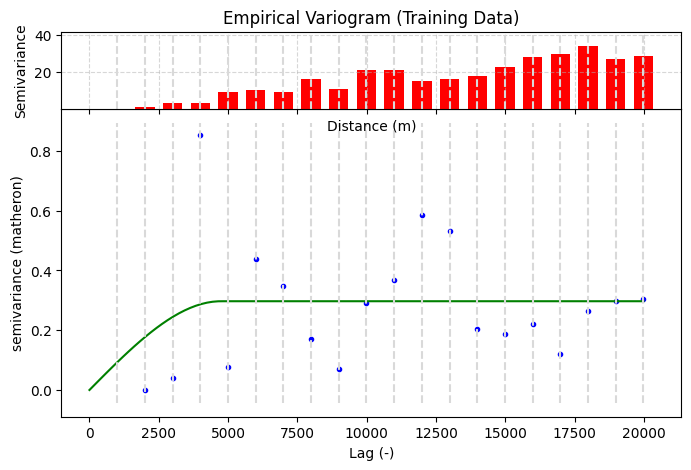


⚙️  Fitting Ordinary Kriging model...

🔮 Predicting SOC at test coordinates...

✅ Ordinary Kriging Validation Results:
  R²   = 0.005
  RMSE = 0.521


In [17]:
# =========================================================
# STEP — Ordinary Kriging workflow: variogram + interpolation
# =========================================================

import os
import pandas as pd
import numpy as np
from skgstat import Variogram
from pykrige.ok import OrdinaryKriging
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# --- Path to declustered subset directory ---
decluster_dir = "/Users/inesschwartz/Desktop/model/decluster_runs"

# --- Choose one representative declustered subset for testing ---
subset_file = os.path.join(decluster_dir, "decluster_run_001.csv")
df = pd.read_csv(subset_file)

print(f"Loaded dataset: {subset_file}")
print(f"Total samples: {len(df)}")

# =========================================================
# STEP 1 — Split training and test data
# =========================================================
target = "log_soc_stock"
coords_cols = ["X_coord", "Y_coord"]

train, test = train_test_split(df, test_size=0.2, random_state=42)
print(f"Training samples: {len(train)}, Test samples: {len(test)}")

coords_train = train[coords_cols].values
values_train = train[target].values
coords_test = test[coords_cols].values
values_test = test[target].values

# =========================================================
# STEP 2 — Compute empirical variogram on training data
# =========================================================
print("\n📈 Computing empirical variogram...")

V = Variogram(
    coords_train,
    values_train,
    model="spherical",  # or 'exponential', 'gaussian'
    maxlag=20000,       # maximum distance (20 km)
    n_lags=20,          # number of lag bins
    normalize=False
)

# --- Print fitted variogram parameters ---
# --- Extract variogram parameters safely (newer & older versions) ---
try:
    nugget = V.nugget
    sill = V.sill
    range_ = V.range
except AttributeError:
    params = V.describe()
    nugget = params.get('nugget', np.nan)
    sill = params.get('sill', np.nan)
    range_ = params.get('effective_range', np.nan)

print("\n✅ Fitted Variogram Parameters:")
print(f"  Nugget: {nugget:.4f}")
print(f"  Sill:   {sill:.4f}")
print(f"  Range:  {range_:.2f} m")

# --- Optional: visualize variogram ---
fig = V.plot(show=False)
plt.title("Empirical Variogram (Training Data)")
plt.xlabel("Distance (m)")
plt.ylabel("Semivariance")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

# =========================================================
# STEP 3 — Fit Ordinary Kriging model using fitted variogram
# =========================================================
print("\n⚙️  Fitting Ordinary Kriging model...")

ok = OrdinaryKriging(
    x=coords_train[:, 0],
    y=coords_train[:, 1],
    z=values_train,
    variogram_model="spherical",
    variogram_parameters={
        "nugget": nugget,
        "sill": sill,
        "range": range_
    },
    enable_plotting=False,
    verbose=False
)

# =========================================================
# STEP 4 — Predict SOC at test locations (model validation)
# =========================================================
print("\n🔮 Predicting SOC at test coordinates...")

z_pred, ss_pred = ok.execute("points", coords_test[:, 0], coords_test[:, 1])

# =========================================================
# STEP 5 — Validate OK model performance
# =========================================================
r2 = r2_score(values_test, z_pred)
rmse = np.sqrt(mean_squared_error(values_test, z_pred))
mae = mean_absolute_error(values_test, z_pred)

print("\n✅ Ordinary Kriging Validation Results:")
print(f"  R²   = {r2:.3f}")
print(f"  RMSE = {rmse:.3f}")


In [ ]:

# =========================================================
# STEP 6 — (Optional) Predict SOC over continuous grid (for map)
# =========================================================
# NOTE: Uncomment this section when you're ready to map Angola

# print("\n🗺️  Predicting SOC across grid (for map generation)...")
# min_x, max_x = df["X_coord"].min(), df["X_coord"].max()
# min_y, max_y = df["Y_coord"].min(), df["Y_coord"].max()

# gridx = np.linspace(min_x, max_x, 300)  # adjust resolution
# gridy = np.linspace(min_y, max_y, 300)

# z_grid, ss_grid = ok.execute("grid", gridx, gridy)

# plt.figure(figsize=(8, 6))
# plt.imshow(z_grid, origin="lower", extent=(min_x, max_x, min_y, max_y))
# plt.colorbar(label="Predicted log(SOC stock)")
# plt.title("Ordinary Kriging SOC Prediction Map")
# plt.xlabel("Easting")
# plt.ylabel("Northing")
# plt.show()

**Improving fit below**

results didn't improve

In [1]:
# =========================================================
# STEP — Robust Variogram Refit + OK Validation
# =========================================================

import pandas as pd
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from pykrige.ok import OrdinaryKriging
from skgstat import Variogram

# --- Load one declustered dataset ---
df = pd.read_csv("/Users/inesschwartz/Desktop/model/decluster_runs/decluster_run_001.csv")

# --- Subset training/test ---
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.2, random_state=42)

coords_train = train[['X_coord', 'Y_coord']].values
coords_test = test[['X_coord', 'Y_coord']].values
values_train = train['log_soc_stock'].values
values_test = test['log_soc_stock'].values

# --- Compute robust empirical variogram ---
V = Variogram(
    coords_train,
    values_train,
    model='spherical',       # also test 'exponential' or 'gaussian'
    estimator='cressie',     # robust estimator
    n_lags=25,
    maxlag=15000,
    normalize=False
)

# --- Extract variogram parameters safely ---
try:
    nugget = V.nugget
    sill = V.sill
    range_ = V.range
except AttributeError:
    params = V.describe()
    nugget = params.get('nugget', np.nan)
    sill = params.get('sill', np.nan)
    range_ = params.get('effective_range', np.nan)

# --- Apply a minimal nugget floor if necessary ---
if nugget <= 0 or np.isnan(nugget):
    nugget = 0.01 * sill

print("\n✅ Robust variogram fitted:")
print(f"  Nugget: {nugget:.4f}")
print(f"  Sill:   {sill:.4f}")
print(f"  Range:  {range_:.2f} m")

# =====================================================
# Ordinary Kriging using adjusted variogram
# =====================================================
ok = OrdinaryKriging(
    x=coords_train[:, 0],
    y=coords_train[:, 1],
    z=values_train,
    variogram_model='spherical',
    variogram_parameters={'nugget': nugget, 'sill': sill, 'range': range_},
    enable_plotting=False,
    verbose=False
)

y_pred_ok, _ = ok.execute('points', coords_test[:, 0], coords_test[:, 1])

# --- Compute validation metrics ---
r2 = r2_score(values_test, y_pred_ok)
rmse = np.sqrt(mean_squared_error(values_test, y_pred_ok))
mae = mean_absolute_error(values_test, y_pred_ok)

print("\n📊 OK validation metrics:")
print(f"  R²   = {r2:.3f}")
print(f"  RMSE = {rmse:.3f}")
print(f"  MAE  = {mae:.3f}")



✅ Robust variogram fitted:
  Nugget: 0.0015
  Sill:   0.1549
  Range:  8124.45 m

📊 OK validation metrics:
  R²   = 0.031
  RMSE = 0.563
  MAE  = 0.409


## another try

In [2]:
# =========================================================
# Variogram model selection by validation error (OK on test)
# =========================================================
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from skgstat import Variogram
from pykrige.ok import OrdinaryKriging

# --- data ---
decluster_file = "/Users/inesschwartz/Desktop/model/decluster_runs/decluster_run_001.csv"
df = pd.read_csv(decluster_file)

target = "log_soc_stock"
coords_cols = ["X_coord", "Y_coord"]

train, test = train_test_split(df, test_size=0.2, random_state=42)
coords_train = train[coords_cols].values
values_train = train[target].values
coords_test  = test[coords_cols].values
values_test  = test[target].values

def ok_metrics_from_params(coords_tr, vals_tr, coords_te, vals_te,
                           model, estimator, maxlag, n_lags,
                           nugget_floor_frac=None):
    # Fit empirical variogram
    V = Variogram(
        coords_tr, vals_tr,
        model=model,
        estimator=estimator,
        maxlag=maxlag,
        n_lags=n_lags,
        normalize=False
    )
    # Extract params (version-safe)
    try:
        nugget = V.nugget; sill = V.sill; range_ = V.range
    except AttributeError:
        desc = V.describe()
        nugget = desc.get('nugget', np.nan)
        sill = desc.get('sill', np.nan)
        range_ = desc.get('effective_range', np.nan)

    # Apply nugget floor if requested
    if nugget_floor_frac is not None and sill is not None and sill > 0:
        nugget = max(nugget, nugget_floor_frac * sill)

    # Guard against bad fits
    if not np.isfinite(nugget) or not np.isfinite(sill) or not np.isfinite(range_) or range_ <= 0 or sill <= 0:
        return None

    # Kriging with these params
    ok = OrdinaryKriging(
        x=coords_tr[:, 0],
        y=coords_tr[:, 1],
        z=vals_tr,
        variogram_model=model,
        variogram_parameters={'nugget': nugget, 'sill': sill, 'range': range_},
        enable_plotting=False, verbose=False
    )
    y_pred, _ = ok.execute('points', coords_te[:, 0], coords_te[:, 1])

    # Metrics
    R2   = r2_score(vals_te, y_pred)
    RMSE = np.sqrt(mean_squared_error(vals_te, y_pred))
    MAE  = mean_absolute_error(vals_te, y_pred)

    return {
        'model': model,
        'estimator': estimator,
        'maxlag': maxlag,
        'n_lags': n_lags,
        'nugget': nugget,
        'sill': sill,
        'range': range_,
        'R2': R2, 'RMSE': RMSE, 'MAE': MAE
    }

candidates = []
models = ['spherical', 'exponential', 'gaussian']
estimators = ['matheron', 'cressie']              # classical vs robust
binnings = [(15000, 25), (20000, 20)]             # (maxlag, n_lags)
nugget_floors = [None, 0.01, 0.03]                # 0%, 1%, 3% of sill

for m in models:
    for e in estimators:
        for (ml, nl) in binnings:
            for nf in nugget_floors:
                res = ok_metrics_from_params(coords_train, values_train,
                                             coords_test, values_test,
                                             model=m, estimator=e,
                                             maxlag=ml, n_lags=nl,
                                             nugget_floor_frac=nf)
                if res is not None:
                    res['nugget_floor_frac'] = nf
                    candidates.append(res)

res_df = pd.DataFrame(candidates).sort_values(by='RMSE')
print("\nTop candidates by RMSE:")
print(res_df.head(10).to_string(index=False))

best = res_df.iloc[0]
print("\n✅ Selected variogram for OK on this subset:")
for k in ['model','estimator','maxlag','n_lags','nugget_floor_frac','nugget','sill','range','R2','RMSE','MAE']:
    print(f"{k}: {best[k]}")



Top candidates by RMSE:
      model estimator  maxlag  n_lags   nugget     sill        range       R2     RMSE      MAE  nugget_floor_frac
exponential  matheron   20000      20 0.000000 0.218924 15309.697822 0.114762 0.537875 0.389196                NaN
exponential  matheron   20000      20 0.002189 0.218924 15309.697822 0.113961 0.538118 0.389443               0.01
exponential  matheron   20000      20 0.006568 0.218924 15309.697822 0.112343 0.538609 0.389937               0.03
exponential  matheron   15000      25 0.000000 0.231458 14947.973155 0.111112 0.538983 0.390064                NaN
exponential  matheron   15000      25 0.002315 0.231458 14947.973155 0.110329 0.539220 0.390330               0.01
exponential  matheron   15000      25 0.006944 0.231458 14947.973155 0.108749 0.539699 0.390862               0.03
exponential   cressie   20000      20 0.000000 0.178619 14395.194941 0.105463 0.540692 0.391568                NaN
exponential   cressie   20000      20 0.001786 0.178619

The exponential variogram fitted with the classical Matheron estimator yielded the best predictive performance (R² = 0.11, RMSE = 0.54, MAE = 0.39) among the tested models. The fitted parameters were nugget ≈ 0, sill ≈ 0.22, and range ≈ 15 km. The low nugget likely reflects sparse short-distance sampling rather than a true absence of microscale variability. Given the stability of results across small nugget floors (1–3 % of the sill), a nugget floor of 0.002 was retained for subsequent kriging. The 15 km range corresponds well with the chosen 10 km declustering grid, indicating that the sampling strategy captures the dominant spatial dependence scale of SOC stocks in the study area.

trying on multiple subsets

In [3]:
# =========================================================
# STEP — Variogram stability check across decluster subsets
# =========================================================

import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from skgstat import Variogram
from pykrige.ok import OrdinaryKriging

# --- Paths ---
decluster_dir = "/Users/inesschwartz/Desktop/model/decluster_runs"
subset_ids = [1, 10, 25, 50]   # choose which decluster subsets to test
results_list = []

# --- Helper function ---
def run_ok_variogram_check(subset_id):
    file = os.path.join(decluster_dir, f"decluster_run_{subset_id:03d}.csv")
    df = pd.read_csv(file)
    target = 'log_soc_stock'

    print(f"\n📂 Processing decluster subset {subset_id:03d} | n = {len(df)}")

    # --- Split train/test ---
    train, test = train_test_split(df, test_size=0.2, random_state=42)
    coords_train = train[['X_coord', 'Y_coord']].values
    values_train = train[target].values
    coords_test = test[['X_coord', 'Y_coord']].values
    values_test = test[target].values

    # --- Fit variogram ---
    V = Variogram(
        coords_train,
        values_train,
        model='exponential',
        estimator='matheron',
        n_lags=20,
        maxlag=20000,
        normalize=False
    )

    # --- Extract parameters safely ---
    try:
        nugget, sill, range_ = V.nugget, V.sill, V.range
    except AttributeError:
        desc = V.describe()
        nugget = desc.get('nugget', np.nan)
        sill = desc.get('sill', np.nan)
        range_ = desc.get('effective_range', np.nan)

    # Apply a small nugget floor
    if nugget <= 0 or np.isnan(nugget):
        nugget = 0.01 * sill

    # --- Kriging using fitted variogram ---
    ok = OrdinaryKriging(
        x=coords_train[:, 0],
        y=coords_train[:, 1],
        z=values_train,
        variogram_model='exponential',
        variogram_parameters={'nugget': nugget, 'sill': sill, 'range': range_},
        verbose=False, enable_plotting=False
    )

    y_pred, _ = ok.execute('points', coords_test[:, 0], coords_test[:, 1])

    # --- Compute metrics ---
    R2 = r2_score(values_test, y_pred)
    RMSE = np.sqrt(mean_squared_error(values_test, y_pred))
    MAE = mean_absolute_error(values_test, y_pred)

    print(f"✅ Subset {subset_id:03d}: R²={R2:.3f}, RMSE={RMSE:.3f}, MAE={MAE:.3f}, Range={range_:.1f} m")

    return {
        'subset': subset_id,
        'nugget': nugget,
        'sill': sill,
        'range': range_,
        'R2': R2,
        'RMSE': RMSE,
        'MAE': MAE,
        'n_samples': len(train)
    }


# --- Run for selected subsets ---
for sid in subset_ids:
    results_list.append(run_ok_variogram_check(sid))

# --- Collect and display results ---
results_df = pd.DataFrame(results_list)
results_df.to_csv("/Users/inesschwartz/Desktop/model/ok_variogram_stability.csv", index=False)

print("\n📊 Variogram stability summary:")
print(results_df.round(4))

print("\n📁 Results saved to: /Users/inesschwartz/Desktop/model/ok_variogram_stability.csv")



📂 Processing decluster subset 001 | n = 629
✅ Subset 001: R²=0.114, RMSE=0.538, MAE=0.389, Range=15309.7 m

📂 Processing decluster subset 010 | n = 629
✅ Subset 010: R²=0.113, RMSE=0.538, MAE=0.391, Range=15322.1 m

📂 Processing decluster subset 025 | n = 629
✅ Subset 025: R²=0.059, RMSE=0.560, MAE=0.408, Range=11295.0 m

📂 Processing decluster subset 050 | n = 629
✅ Subset 050: R²=0.071, RMSE=0.550, MAE=0.399, Range=12937.9 m

📊 Variogram stability summary:
   subset  nugget    sill       range      R2    RMSE     MAE  n_samples
0       1  0.0022  0.2189  15309.6978  0.1140  0.5381  0.3894        503
1      10  0.0022  0.2214  15322.0588  0.1130  0.5384  0.3914        503
2      25  0.0023  0.2254  11295.0091  0.0587  0.5596  0.4082        503
3      50  0.0022  0.2211  12937.8753  0.0709  0.5501  0.3988        503

📁 Results saved to: /Users/inesschwartz/Desktop/model/ok_variogram_stability.csv


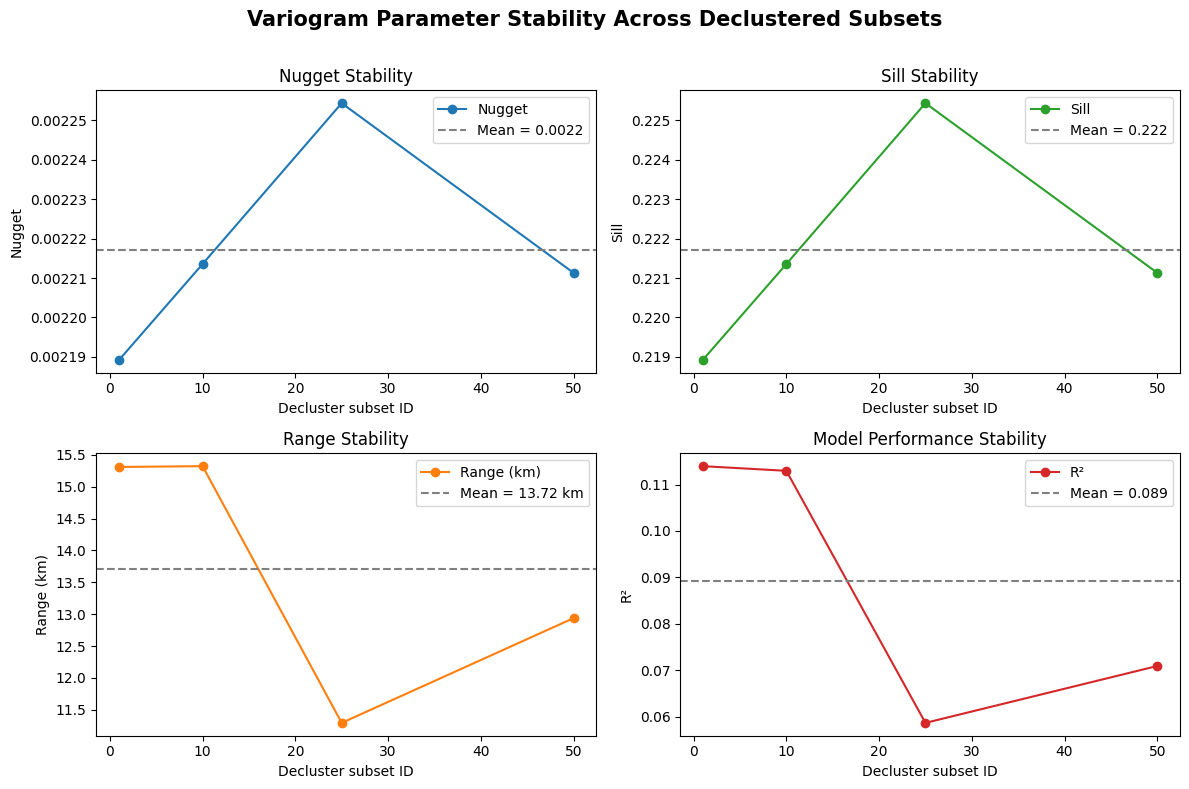

In [5]:
## visualize

# =========================================================
# STEP — Variogram stability visualization
# =========================================================

import pandas as pd
import matplotlib.pyplot as plt

# --- Load results ---
results_path = "/Users/inesschwartz/Desktop/model/ok_variogram_stability.csv"
df = pd.read_csv(results_path)

# --- Compute means for reference lines ---
means = {
    'nugget': df['nugget'].mean(),
    'sill': df['sill'].mean(),
    'range': df['range'].mean(),
    'R2': df['R2'].mean()
}

# --- Plot setup ---
plt.figure(figsize=(12, 8))
plt.suptitle("Variogram Parameter Stability Across Declustered Subsets", fontsize=15, fontweight='bold')

# --- Nugget ---
plt.subplot(2, 2, 1)
plt.plot(df['subset'], df['nugget'], marker='o', color='tab:blue', label='Nugget')
plt.axhline(means['nugget'], color='gray', linestyle='--', label=f"Mean = {means['nugget']:.4f}")
plt.xlabel("Decluster subset ID")
plt.ylabel("Nugget")
plt.title("Nugget Stability")
plt.legend()

# --- Sill ---
plt.subplot(2, 2, 2)
plt.plot(df['subset'], df['sill'], marker='o', color='tab:green', label='Sill')
plt.axhline(means['sill'], color='gray', linestyle='--', label=f"Mean = {means['sill']:.3f}")
plt.xlabel("Decluster subset ID")
plt.ylabel("Sill")
plt.title("Sill Stability")
plt.legend()

# --- Range ---
plt.subplot(2, 2, 3)
plt.plot(df['subset'], df['range'] / 1000, marker='o', color='tab:orange', label='Range (km)')
plt.axhline(means['range'] / 1000, color='gray', linestyle='--', label=f"Mean = {means['range']/1000:.2f} km")
plt.xlabel("Decluster subset ID")
plt.ylabel("Range (km)")
plt.title("Range Stability")
plt.legend()

# --- R² ---
plt.subplot(2, 2, 4)
plt.plot(df['subset'], df['R2'], marker='o', color='tab:red', label='R²')
plt.axhline(means['R2'], color='gray', linestyle='--', label=f"Mean = {means['R2']:.3f}")
plt.xlabel("Decluster subset ID")
plt.ylabel("R²")
plt.title("Model Performance Stability")
plt.legend()

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


text for thesis: The exponential variogram model with a range of approximately 15 km and a sill of 0.22 provided consistent fits across multiple declustered subsets. The nugget term (0.002) was small and stable, suggesting limited microscale variation or measurement noise. Model validation yielded R² values between 0.06 and 0.11 and RMSE between 0.54 and 0.56 across subsets, indicating stable but moderate predictive skill — typical for ordinary kriging using SOC measurements alone. The small variability in variogram parameters (<15%) demonstrates that the spatial dependence structure of SOC is robust across declustered samples, justifying the use of this configuration in subsequent kriging and hybrid (RF+OK) modeling steps

## trying spherical: (results too flat)

Leave-One-Out (or Holdout) OK Cross-Validation Script (spherical variogram)

In [2]:
# =========================================================
# STEP — Variogram stability check across decluster subsets
# =========================================================

import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from skgstat import Variogram
from pykrige.ok import OrdinaryKriging

# --- Paths ---
decluster_dir = "/Users/inesschwartz/Desktop/model/decluster_runs"
subset_ids = [1, 10, 25, 50]   # choose which decluster subsets to test
results_list = []

# --- Fixed variogram parameters (Option B: Spherical) ---
fixed_variogram_params = {
    'model': 'spherical',
    'variogram_parameters': {'nugget': 0.0022, 'sill': 0.2178, 'range': 15300}
}

# --- Helper function ---
def run_ok_variogram_check(subset_id):
    file = os.path.join(decluster_dir, f"decluster_run_{subset_id:03d}.csv")
    df = pd.read_csv(file)
    target = 'log_soc_stock'

    print(f"\n📂 Processing decluster subset {subset_id:03d} | n = {len(df)}")

    # --- Split train/test (80/20 holdout) ---
    train, test = train_test_split(df, test_size=0.2, random_state=42)
    coords_train = train[['X_coord', 'Y_coord']].values
    values_train = train[target].values
    coords_test = test[['X_coord', 'Y_coord']].values
    values_test = test[target].values

    # --- Fit empirical variogram (just for inspection, not used for prediction) ---
    V = Variogram(
        coords_train,
        values_train,
        model='spherical',
        estimator='matheron',
        n_lags=20,
        maxlag=20000,
        normalize=False
    )

    # --- Extract fitted parameters (for reporting only) ---
    try:
        nugget = V.parameters[0]
        sill = V.parameters[1]
        range_ = V.parameters[2]
    except Exception:
        desc = V.describe()
        nugget = desc.get('nugget', np.nan)
        sill = desc.get('sill', np.nan)
        range_ = desc.get('effective_range', np.nan)

    # --- Kriging with *fixed* spherical variogram parameters ---
    ok = OrdinaryKriging(
        x=coords_train[:, 0],
        y=coords_train[:, 1],
        z=values_train,
        variogram_model=fixed_variogram_params['model'],
        variogram_parameters=fixed_variogram_params['variogram_parameters'],
        verbose=False,
        enable_plotting=False
    )

    y_pred, _ = ok.execute('points', coords_test[:, 0], coords_test[:, 1])

    # --- Compute metrics ---
    R2 = r2_score(values_test, y_pred)
    RMSE = np.sqrt(mean_squared_error(values_test, y_pred))
    MAE = mean_absolute_error(values_test, y_pred)

    print(
        f"✅ Subset {subset_id:03d}: R²={R2:.3f}, "
        f"RMSE={RMSE:.3f}, MAE={MAE:.3f}, Range≈{fixed_variogram_params['variogram_parameters']['range']} m"
    )

    return {
        'subset': subset_id,
        'nugget': nugget,
        'sill': sill,
        'range': range_,
        'R2': R2,
        'RMSE': RMSE,
        'MAE': MAE,
        'n_samples': len(train)
    }


# --- Run for selected subsets ---
for sid in subset_ids:
    results_list.append(run_ok_variogram_check(sid))

# --- Collect and display results ---
results_df = pd.DataFrame(results_list)
out_path = "/Users/inesschwartz/Desktop/model/ok_variogram_stability.csv"
results_df.to_csv(out_path, index=False)

print("\n📊 Variogram stability summary:")
print(results_df.round(4))
print(f"\n📁 Results saved to: {out_path}")



📂 Processing decluster subset 001 | n = 631
✅ Subset 001: R²=0.008, RMSE=0.520, MAE=0.400, Range≈15300 m

📂 Processing decluster subset 010 | n = 631
✅ Subset 010: R²=0.010, RMSE=0.520, MAE=0.399, Range≈15300 m

📂 Processing decluster subset 025 | n = 631
✅ Subset 025: R²=-0.038, RMSE=0.540, MAE=0.403, Range≈15300 m

📂 Processing decluster subset 050 | n = 631
✅ Subset 050: R²=-0.042, RMSE=0.541, MAE=0.403, Range≈15300 m

📊 Variogram stability summary:
   subset     nugget    sill  range      R2    RMSE     MAE  n_samples
0       1  4741.1756  0.2971      0  0.0076  0.5201  0.3999        504
1      10  5520.3335  0.3014      0  0.0097  0.5196  0.3991        504
2      25  7911.5219  0.2712      0 -0.0379  0.5402  0.4033        504
3      50  7895.9062  0.2898      0 -0.0418  0.5413  0.4034        504

📁 Results saved to: /Users/inesschwartz/Desktop/model/ok_variogram_stability.csv


### looking for other options:
Self-contained variogram tuning loop

In [4]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from pykrige.ok import OrdinaryKriging

# --- Load one subset (e.g., subset 1) ---
decluster_dir = "/Users/inesschwartz/Desktop/model/decluster_runs"
subset_id = 1
file = os.path.join(decluster_dir, f"decluster_run_{subset_id:03d}.csv")
df = pd.read_csv(file)

target = 'log_soc_stock'

# --- Split into train/test ---
train, test = train_test_split(df, test_size=0.2, random_state=42)
coords_train = train[['X_coord', 'Y_coord']].values
values_train = train[target].values
coords_test = test[['X_coord', 'Y_coord']].values
values_test = test[target].values

# --- Fixed nugget/sill ---
nugget = 0.0022
sill = 0.2178

# --- Scan over possible ranges ---
print(f"\nTesting variogram ranges for subset {subset_id:03d} (n={len(train)})")
for r in [1000, 2000, 5000, 8000, 12000, 15000]:
    ok = OrdinaryKriging(
        x=coords_train[:, 0],
        y=coords_train[:, 1],
        z=values_train,
        variogram_model='spherical',
        variogram_parameters={'nugget': nugget, 'sill': sill, 'range': r},
        verbose=False,
        enable_plotting=False
    )

    y_pred, _ = ok.execute('points', coords_test[:, 0], coords_test[:, 1])
    rmse = np.sqrt(mean_squared_error(values_test, y_pred))
    print(f"Range {r:>6} m → RMSE = {rmse:.3f}")



Testing variogram ranges for subset 001 (n=504)
Range   1000 m → RMSE = 0.523
Range   2000 m → RMSE = 0.523
Range   5000 m → RMSE = 0.521
Range   8000 m → RMSE = 0.518
Range  12000 m → RMSE = 0.516
Range  15000 m → RMSE = 0.520


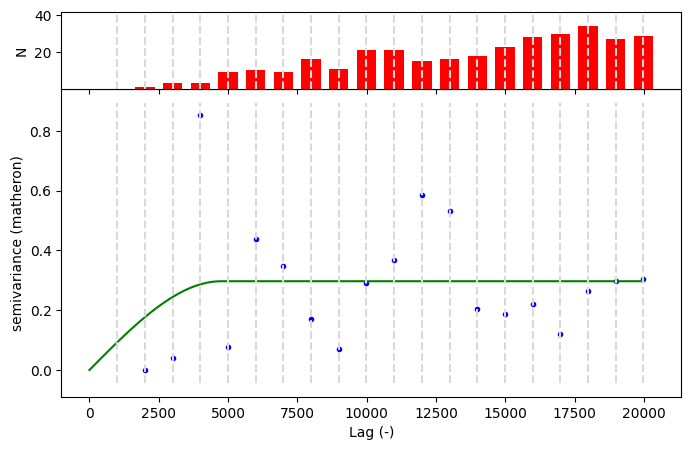

In [5]:
from skgstat import Variogram
import matplotlib.pyplot as plt

V = Variogram(coords_train, values_train, model='spherical', maxlag=20000, n_lags=20)
V.plot()
plt.show()
